In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from collections import Counter
from scipy.stats import linregress
import yaml

import sys
import os
sys.path.append(os.path.abspath('../..'))
from utils.plotting_utils import *

plt.rcParams['pdf.fonttype'] = 42  # For PDF: embed text as text, not paths
plt.rcParams['svg.fonttype'] = 'none'  # For SVG: embed text as text, not paths
#plt.rcParams['font.family'] = 'Arial'

In [9]:
RESULTS_DIR = "../../Benchmark-Models/results"
FIG_DIR = "../../figures/benchmark_models"

#OVERALL PERFORMANCE
test_avgs = pd.read_csv(f"{RESULTS_DIR}/test_avgs.csv")
test_perclass_level1 = pd.read_csv(f"{RESULTS_DIR}/test_perclass_level1.csv")
test_perclass_level2 = pd.read_csv(f"{RESULTS_DIR}/test_perclass_level2.csv")
test_perclass_level3 = pd.read_csv(f"{RESULTS_DIR}/test_perclass_level3.csv")

#SEPERATE PERFORMANCE ON SINGLE- and MULTI-LOCALIZING PROTEINS
test_avgs_single = pd.read_csv(f"{RESULTS_DIR}/test_avgs_single.csv")
test_avgs_multi = pd.read_csv(f"{RESULTS_DIR}/test_avgs_multi.csv")

hou_testset = pd.read_csv("../../datasets/final/hou_testset.csv")
hpa_uniprot_combined_trainset = pd.read_csv("../../datasets/final/hpa_uniprot_combined_trainset.csv")

In [10]:
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

mappings = load_config("../../datasets/final/hierarchical_label_set.yaml")
ordered_labels_level1 = mappings["level1"][:-1] #get rid of plastid
ordered_labels_level2 = mappings["level2"][:-1] #get rid of plastid
ordered_labels_level3 = mappings["level3"][:-1] #get rid of plastid
orders = [ordered_labels_level1, ordered_labels_level2, ordered_labels_level3]

models = ['Random', 'MULocDeep', 'DeepLoc2-ProtT5', 'DeepLoc2-ESM1', 'LAProtT5']
palette = sns.color_palette("rainbow", len(models))
model_colors = {model: palette[i] for i, model in enumerate(models)}

True average number of labels

In [11]:
print("Level1 True Num Labels: ", (hou_testset["level1"].str.count(";")+1).to_numpy().mean())
print(f"Level2 True Num Labels: ", (hou_testset["level2"].str.count(";")+1).to_numpy().mean())
print(f"Level3 True Num Labels: ", (hou_testset["level3"].str.count(";")+1).to_numpy().mean())

Level1 True Num Labels:  1.4066596748820137
Level2 True Num Labels:  1.2658626114315679
Level3 True Num Labels:  1.259045621394861


Look at average metrics

In [12]:
values = ["acc", "macro_ap", "micro_ap", "f1_macro", "f1_micro", "jaccard_macro", "jaccard_micro", "rocauc_macro",	"rocauc_micro",	"mlrap", "cov_error", "num_labels"]
table = test_avgs.pivot_table(index='model', columns='level', values=values).round(3).reindex(["Random", "MULocDeep", "DeepLoc2-ProtT5", "DeepLoc2-ESM1", "LAProtT5"])
table.to_csv(f"{FIG_DIR}/benchmark_avg_metrics.csv")

values = ["acc", "macro_ap", "micro_ap", "f1_macro", "f1_micro", "num_labels"]
test_avgs_for_display = test_avgs.pivot_table(index='model', columns='level', values=values).round(3)
test_avgs_for_display = test_avgs_for_display.reindex(["Random", "MULocDeep", "DeepLoc2-ProtT5", "DeepLoc2-ESM1", "LAProtT5"])
display(test_avgs_for_display)

values = ["jaccard_macro", "jaccard_micro", "rocauc_macro",	"rocauc_micro",	"mlrap", "cov_error"]
test_avgs_for_display = test_avgs.pivot_table(index='model', columns='level', values=values).round(3)
test_avgs_for_display = test_avgs_for_display.reindex(["Random", "MULocDeep", "DeepLoc2-ProtT5", "DeepLoc2-ESM1", "LAProtT5"])
display(test_avgs_for_display)

acc               f1_macro               f1_micro         \
level                1      2      3        1      2      3        1      2   
model                                                                         
Random           0.052  0.069  0.074    0.068  0.146  0.186    0.224  0.261   
MULocDeep        0.227  0.354  0.391    0.304  0.550  0.601    0.460  0.621   
DeepLoc2-ProtT5  0.078  0.334  0.448    0.328  0.569  0.642    0.416  0.631   
DeepLoc2-ESM1    0.109  0.356  0.453    0.339  0.581  0.642    0.422  0.631   
LAProtT5         0.238  0.407  0.512    0.383  0.584  0.653    0.521  0.654   

                       macro_ap               micro_ap                \
level                3        1      2      3        1      2      3   
model                                                                  
Random           0.280      NaN    NaN    NaN      NaN    NaN    NaN   
MULocDeep        0.640    0.290  0.552  0.634    0.590  0.672  0.687   
DeepLoc2-ProtT5  0.688    0.332  0.584  0.669    0.401  0.672  0.718   
DeepLoc2-ESM1    0.686    0.324  0.590  0.662    0.423  0.671  0.703   
LAProtT5         0.705    0.371  0.614  0.682    0.582  0.735  0.755   

                num_labels                
level                    1      2      3  
model                                     
Random               1.569  1.425  1.399  
MULocDeep            2.341  1.489  1.474  
DeepLoc2-ProtT5      3.514  1.755  1.397  
DeepLoc2-ESM1        3.300  1.612  1.404  
LAProtT5             1.910  1.392  1.225

cov_error               jaccard_macro                \
level                   1      2      3             1      2      3   
model                                                                 
Random                NaN    NaN    NaN         0.039  0.085  0.109   
MULocDeep           3.698  2.179  1.984         0.206  0.394  0.442   
DeepLoc2-ProtT5     4.267  2.152  1.942         0.223  0.419  0.486   
DeepLoc2-ESM1       4.271  2.189  1.974         0.232  0.427  0.487   
LAProtT5            3.143  2.006  1.792         0.266  0.436  0.500   

                jaccard_micro                mlrap               rocauc_macro  \
level                       1      2      3      1      2      3            1   
model                                                                           
Random                  0.126  0.150  0.163    NaN    NaN    NaN          NaN   
MULocDeep               0.299  0.450  0.640  0.747  0.783  0.803        0.835   
DeepLoc2-ProtT5         0.262  0.461  0.524  0.634  0.791  0.820        0.850   
DeepLoc2-ESM1           0.268  0.461  0.522  0.637  0.786  0.811        0.845   
LAProtT5                0.352  0.486  0.545  0.742  0.818  0.846        0.867   

                              rocauc_micro                
level                2      3            1      2      3  
model                                                     
Random             NaN    NaN          NaN    NaN    NaN  
MULocDeep        0.866  0.874        0.905  0.906  0.898  
DeepLoc2-ProtT5  0.897  0.903        0.875  0.908  0.905  
DeepLoc2-ESM1    0.891  0.893        0.874  0.904  0.897  
LAProtT5         0.899  0.902        0.921  0.928  0.926

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, -0.03 , .95])


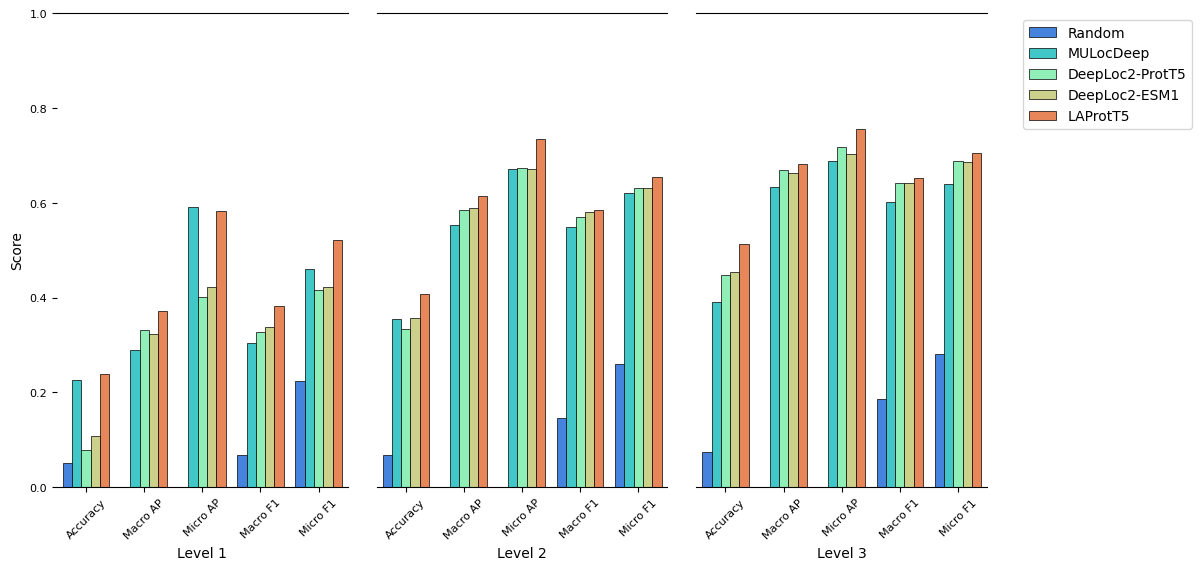

In [13]:
fig, axes = plot_avg_metrics_by_level(
    test_avgs, 
    ["acc", "macro_ap", "micro_ap", "f1_macro", "f1_micro"],
    ["Accuracy", "Macro AP", "Micro AP", "Macro F1", "Micro F1"],
    colors=model_colors,
    model_order = models
    )
fig.savefig(f"{FIG_DIR}/avg_metrics_acc_f1_ap.pdf", bbox_inches='tight', dpi=300)

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, -0.03 , .95])
/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:60: UserWarning: set_ticklabels() should only be used with

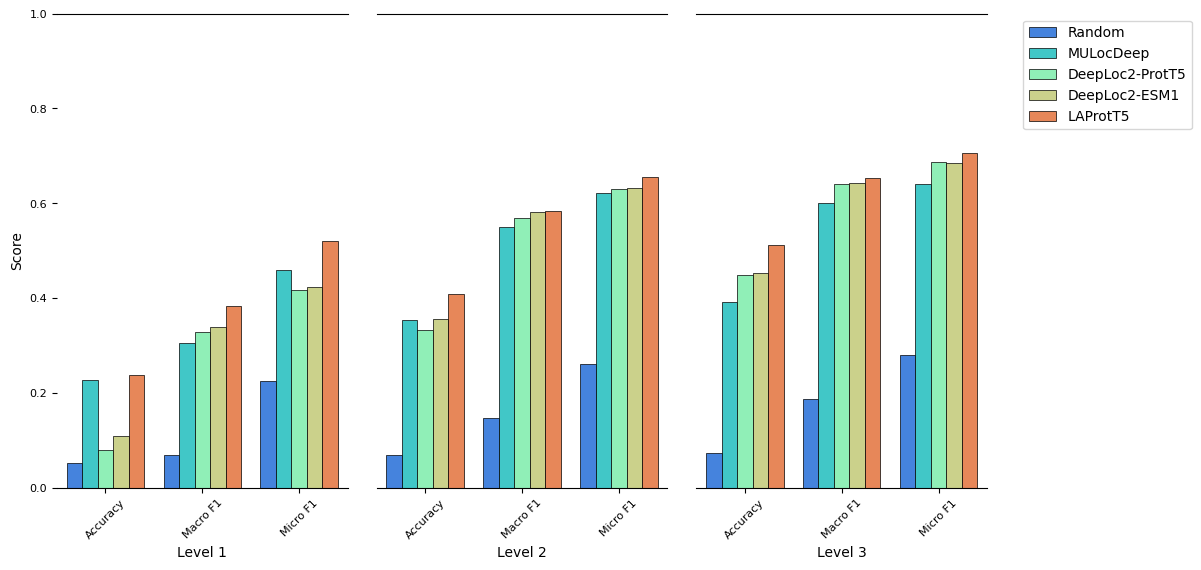

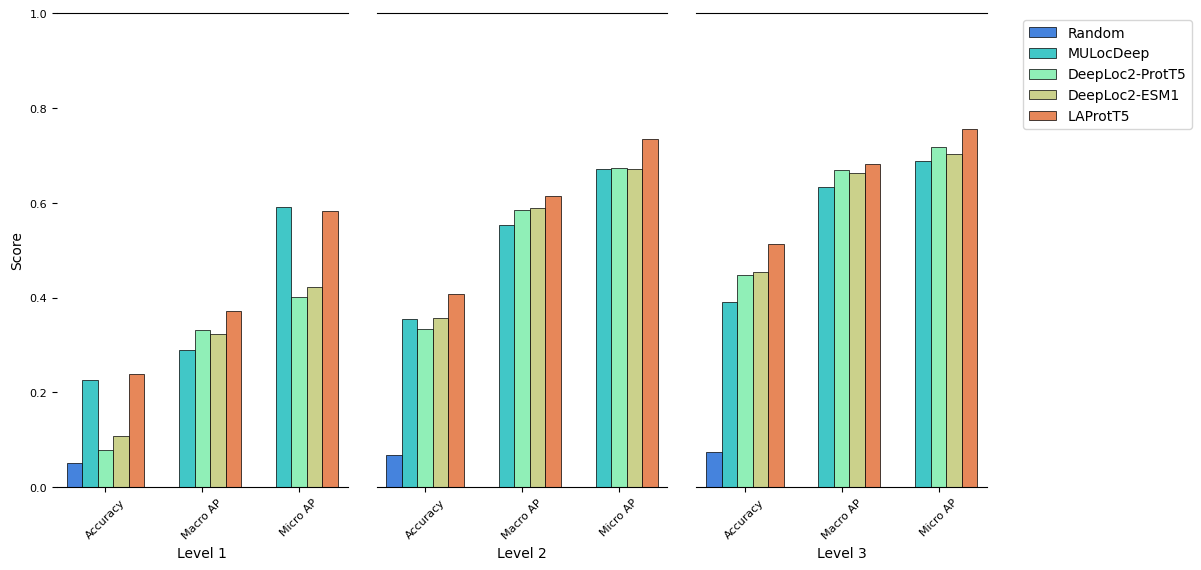

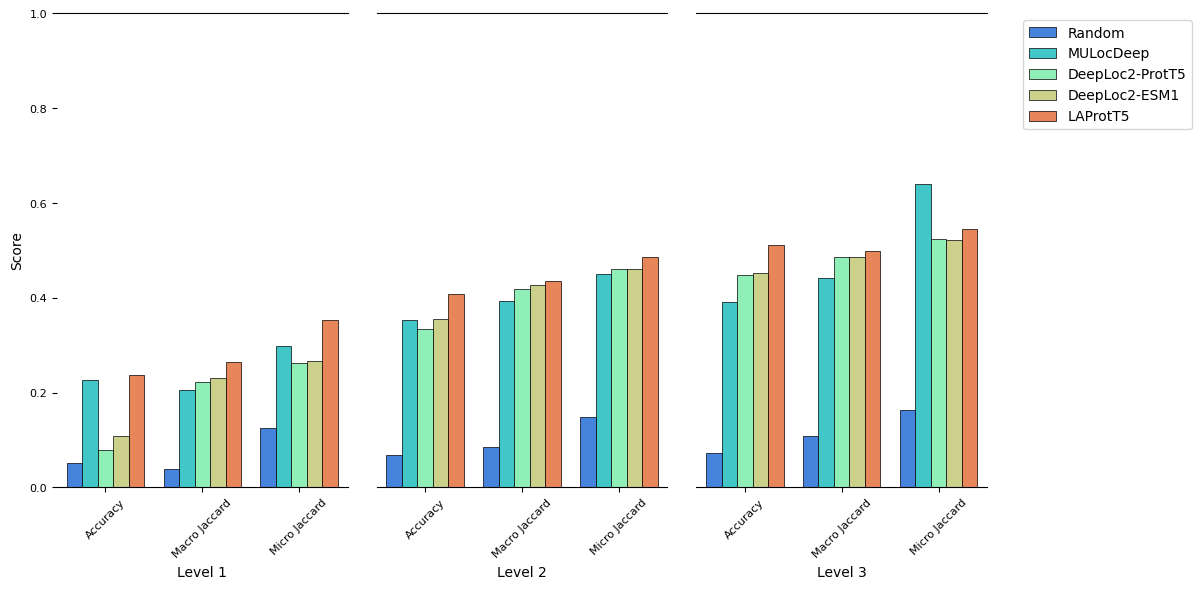

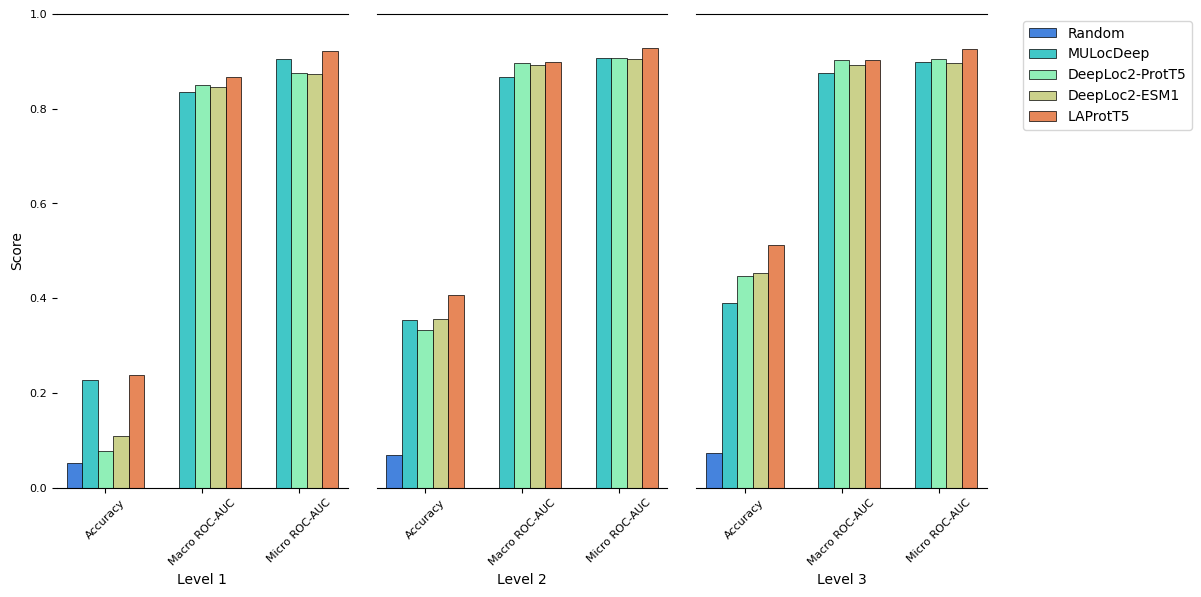

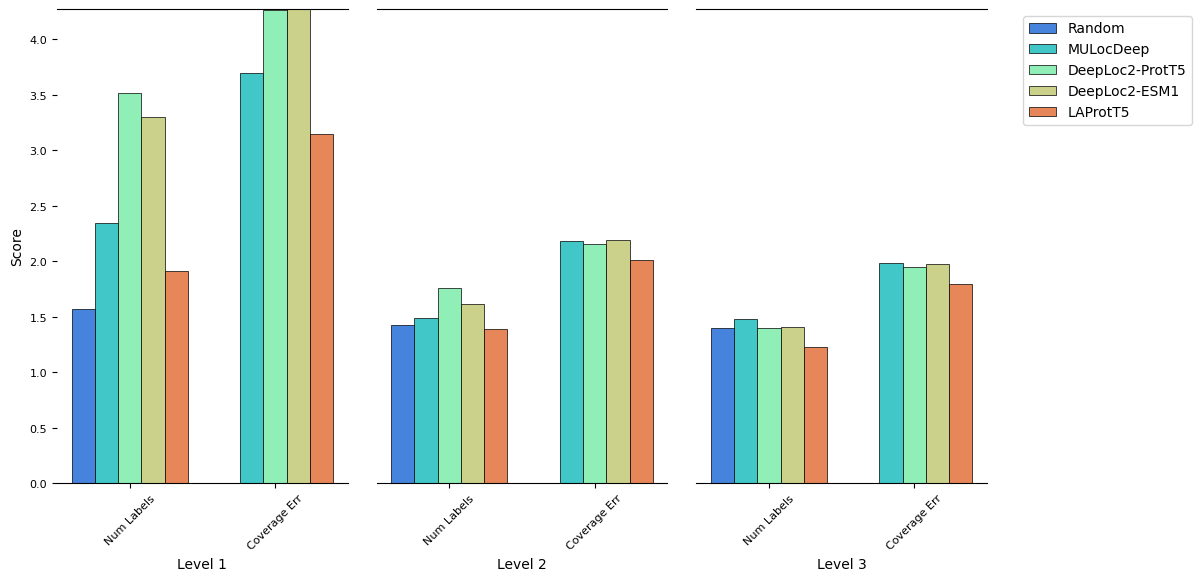

In [14]:
fig, axes = plot_avg_metrics_by_level(
    test_avgs, 
    ["acc", "f1_macro", "f1_micro"],
    ["Accuracy", "Macro F1", "Micro F1"],
    colors=model_colors,
    model_order = models
    )
fig.savefig(f"{FIG_DIR}/avg_metrics_acc_f1.pdf", bbox_inches='tight', dpi=300)

fig, axes = plot_avg_metrics_by_level(
    test_avgs, 
    ["acc", "macro_ap", "micro_ap"],
    ["Accuracy", "Macro AP", "Micro AP"],
    colors=model_colors,
    model_order = models
    )
fig.savefig(f"{FIG_DIR}/avg_metrics_acc_ap.pdf", bbox_inches='tight', dpi=300)

fig, axes = plot_avg_metrics_by_level(
    test_avgs, 
    ["acc", "jaccard_macro", "jaccard_micro"],
    ["Accuracy", "Macro Jaccard", "Micro Jaccard"],
    colors=model_colors,
    model_order = models
    )
fig.savefig(f"{FIG_DIR}/avg_metrics_acc_jaccard.pdf", bbox_inches='tight', dpi=300)

fig, axes = plot_avg_metrics_by_level(
    test_avgs, 
    ["acc", "rocauc_macro", "rocauc_micro"],
    ["Accuracy", "Macro ROC-AUC", "Micro ROC-AUC"],
    colors=model_colors,
    model_order = models
    )
fig.savefig(f"{FIG_DIR}/avg_metrics_acc_rocauc.pdf", bbox_inches='tight', dpi=300)

fig, axes = plot_avg_metrics_by_level(
    test_avgs, 
    ["num_labels", "cov_error"],
    ["Num Labels", "Coverage Err"],
    colors=model_colors,
    model_order=models
    )
fig.savefig(f"{FIG_DIR}/avg_metrics_label_coverror.pdf", bbox_inches='tight', dpi=300)

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/home/groups/emmalu/zwefers/seq2loc/utils/plotting_utils.py:134: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=colors[model], label=model, edgecolor="black", linewidth=0.5) for model in models


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

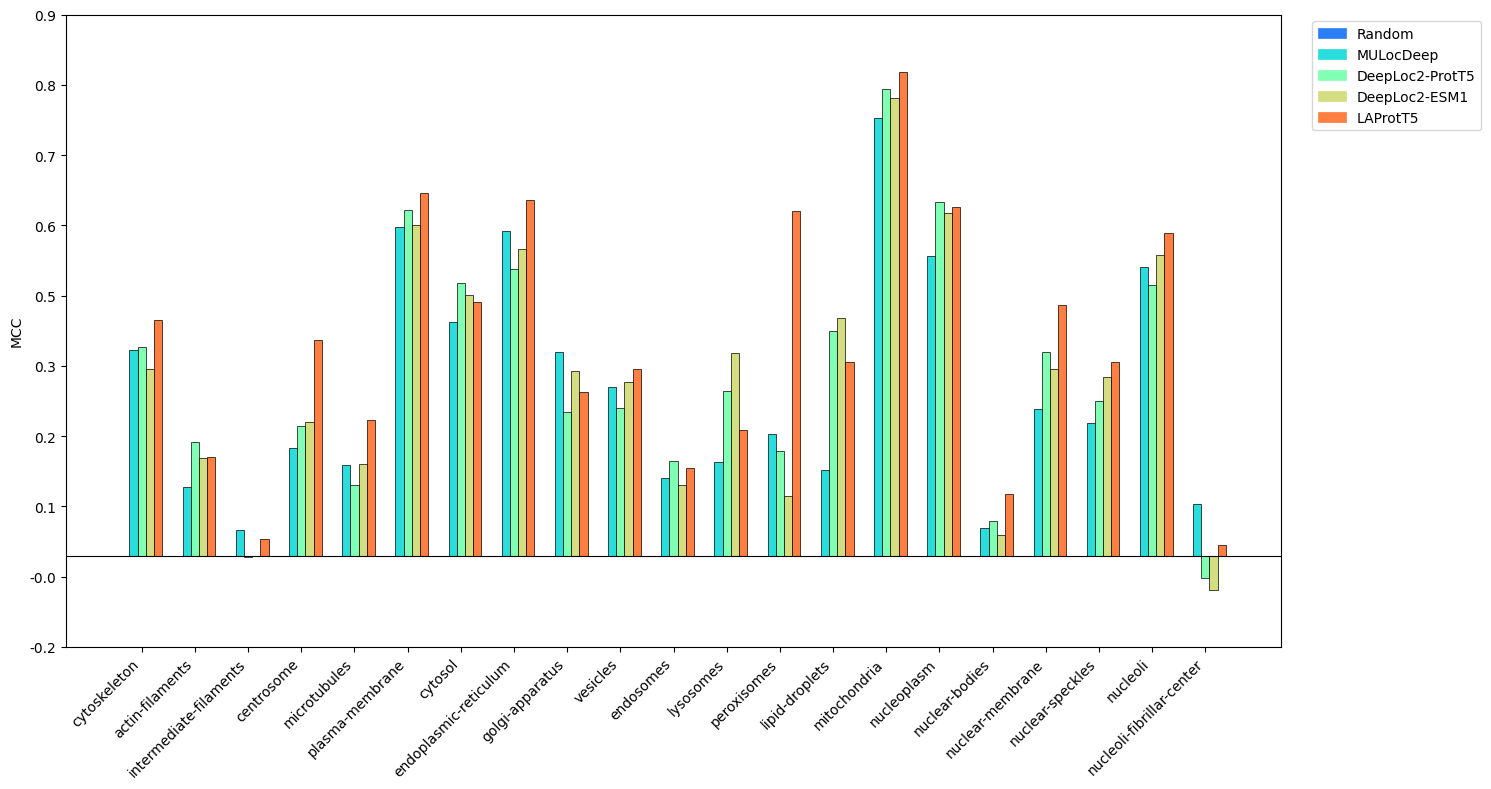

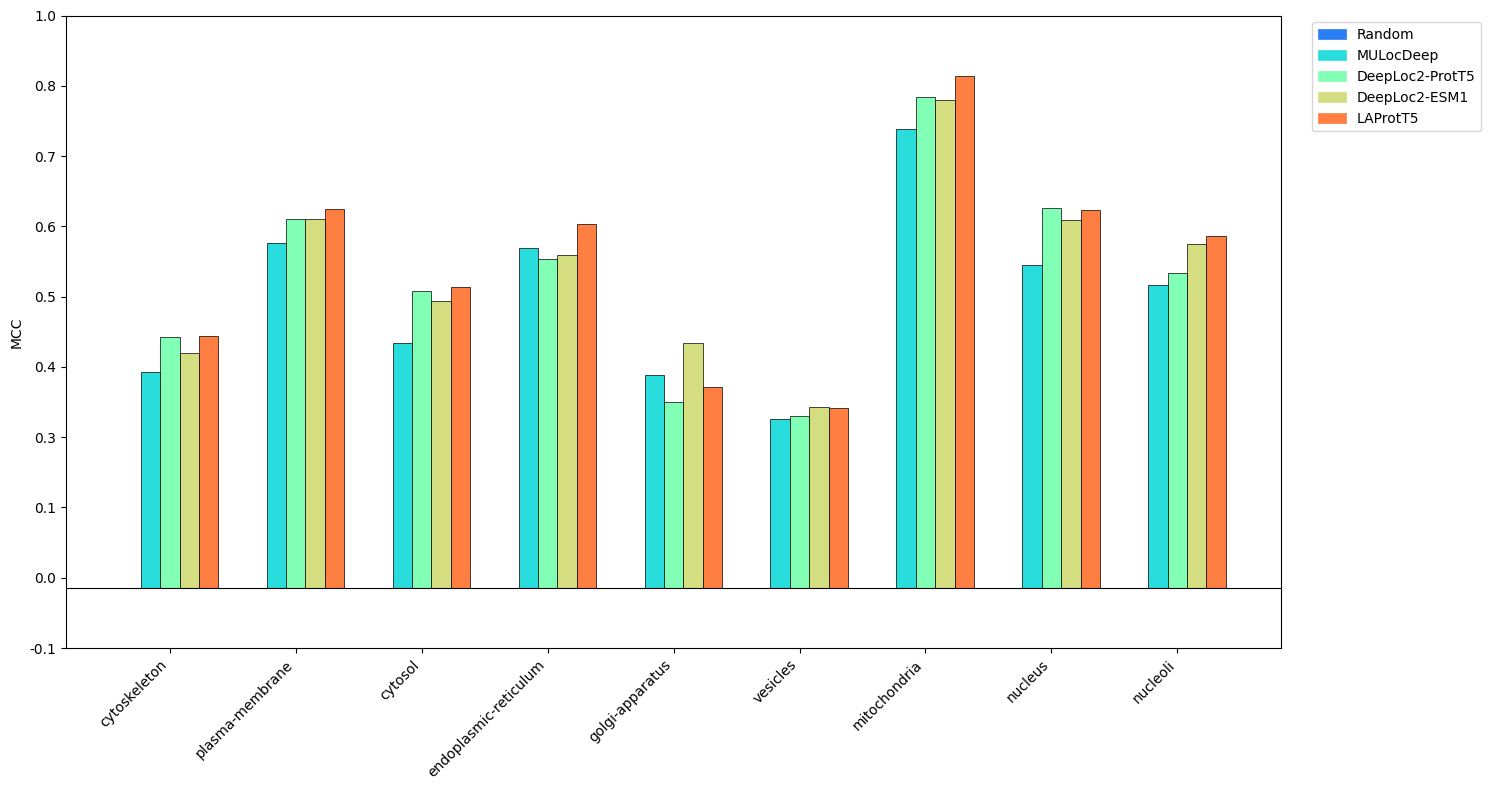

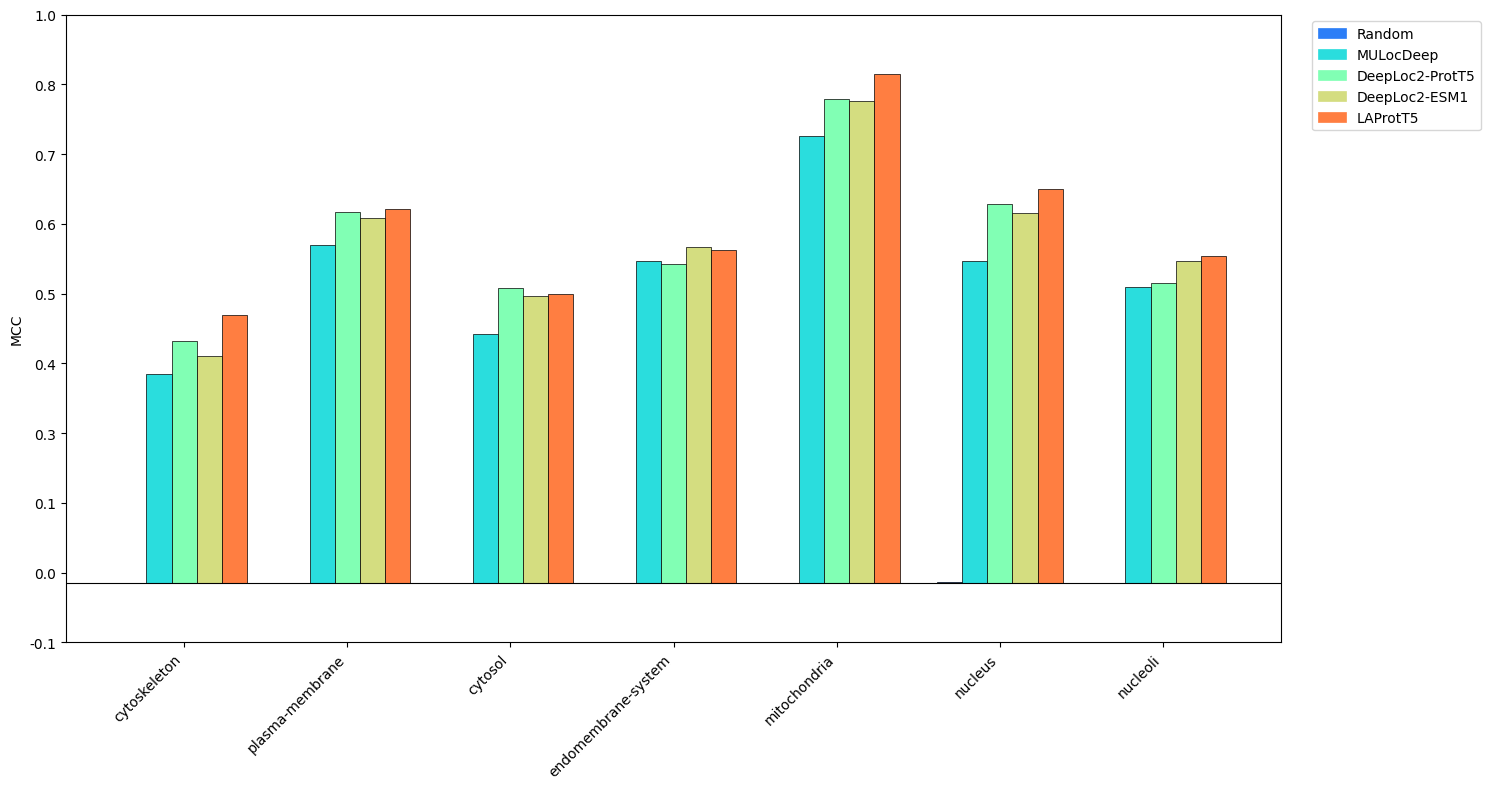

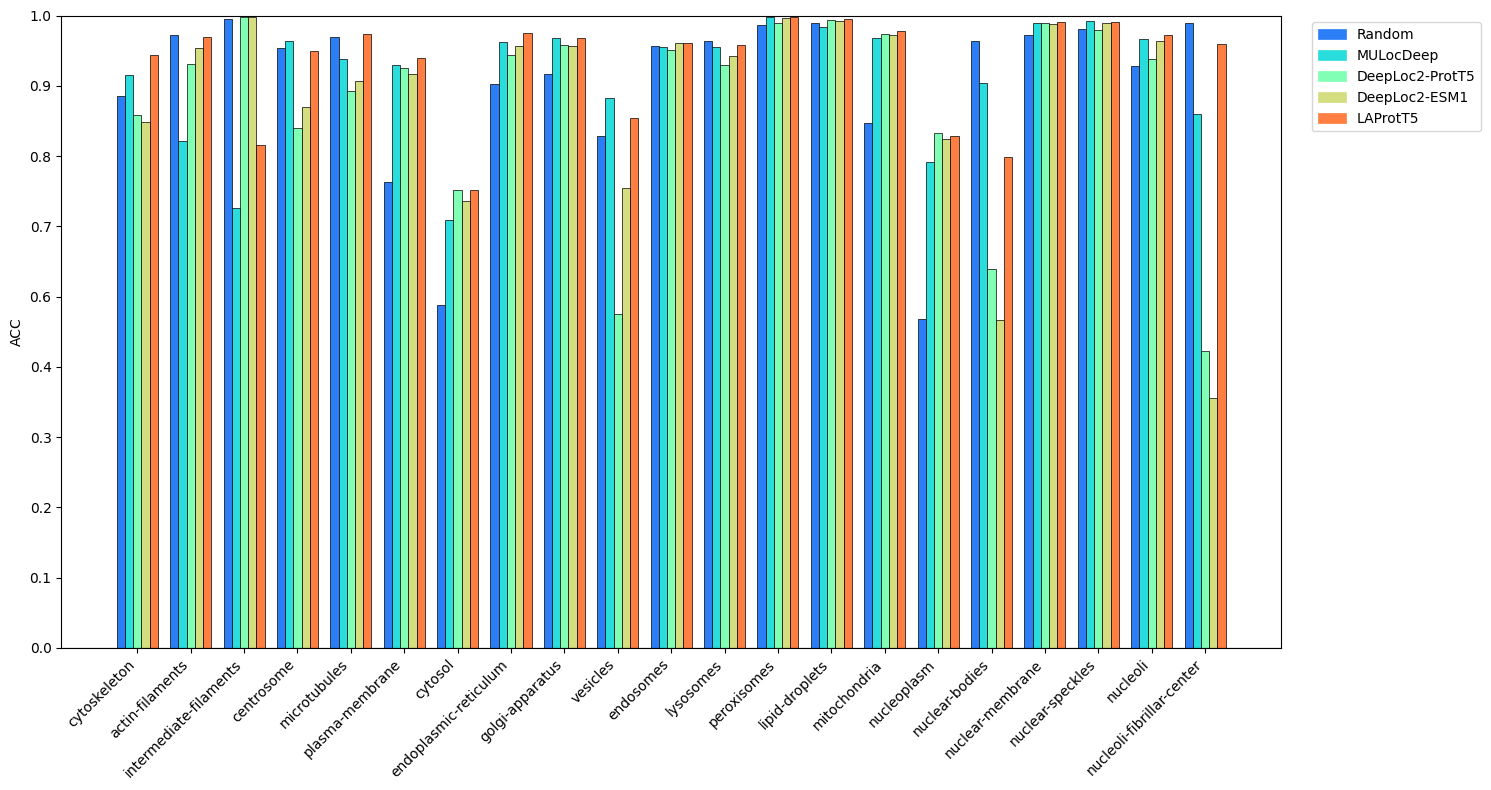

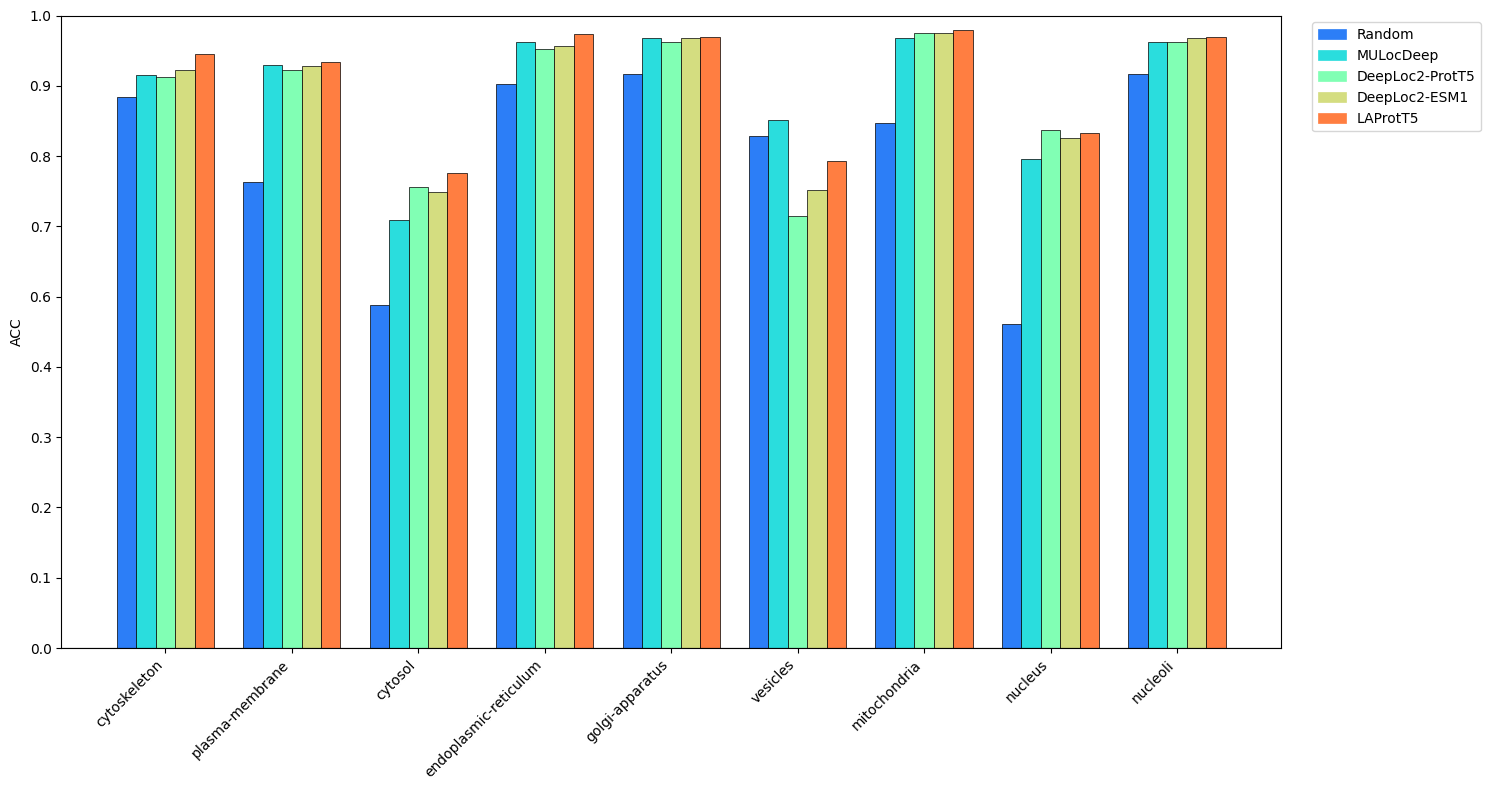

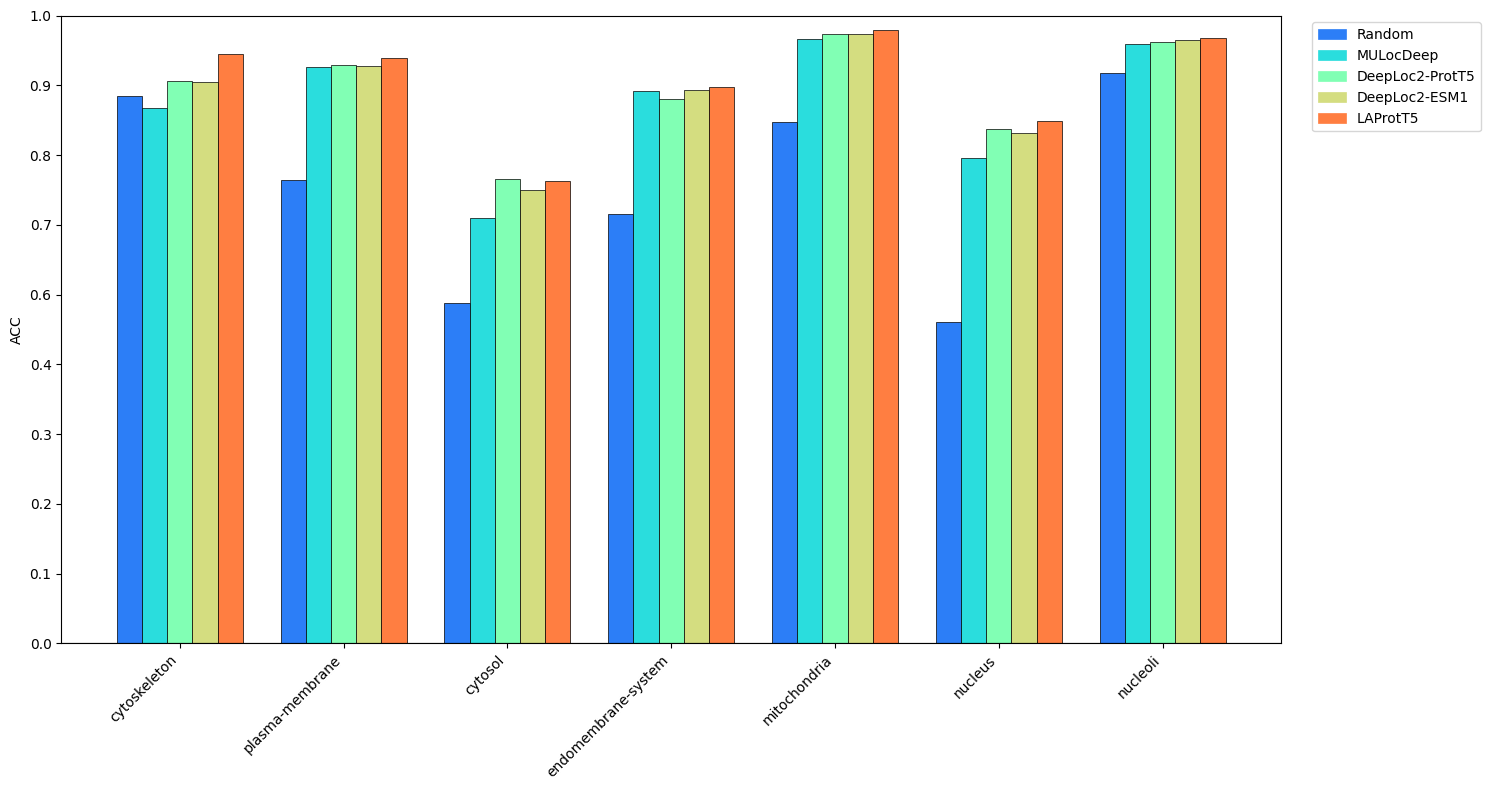

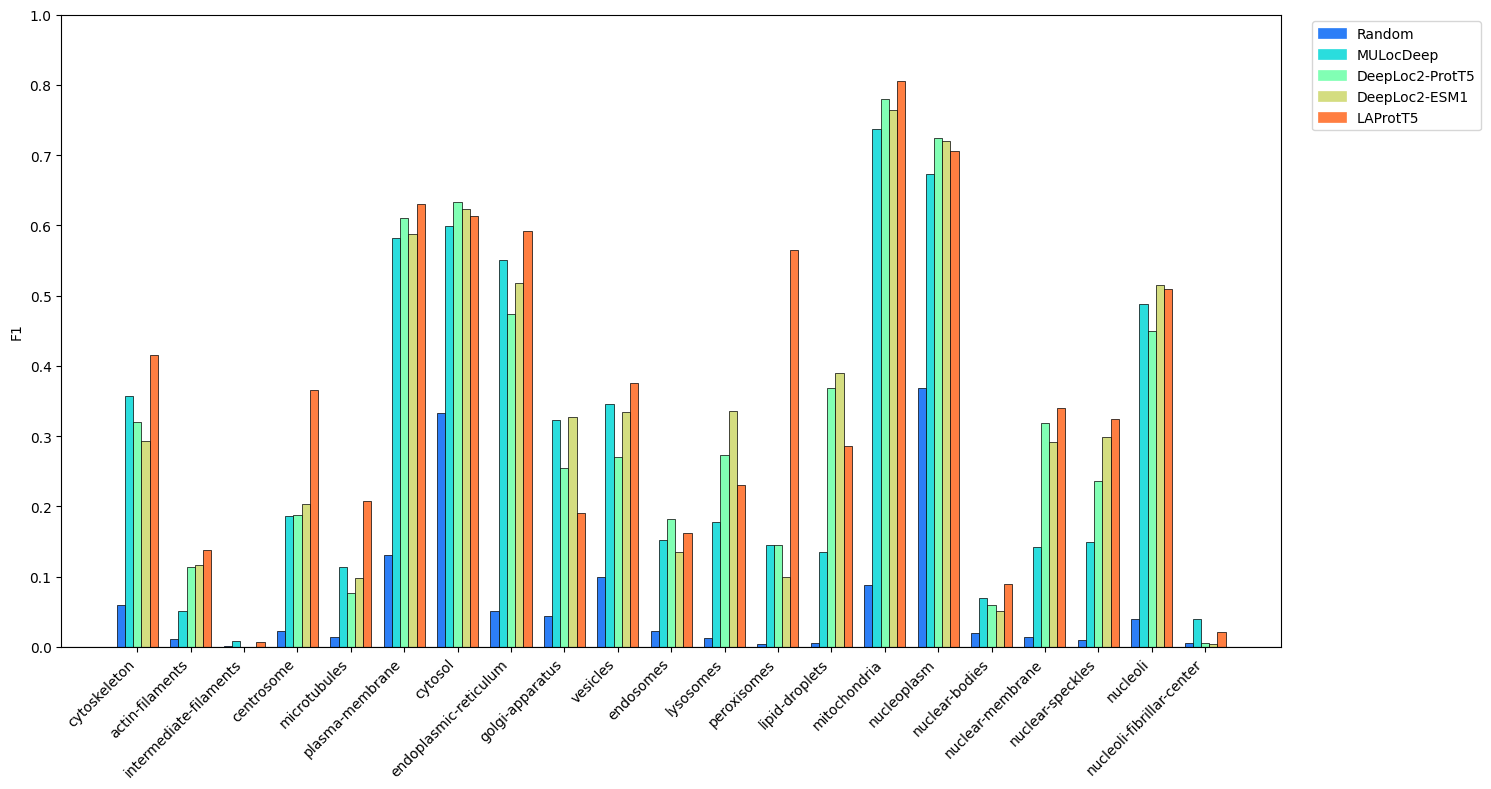

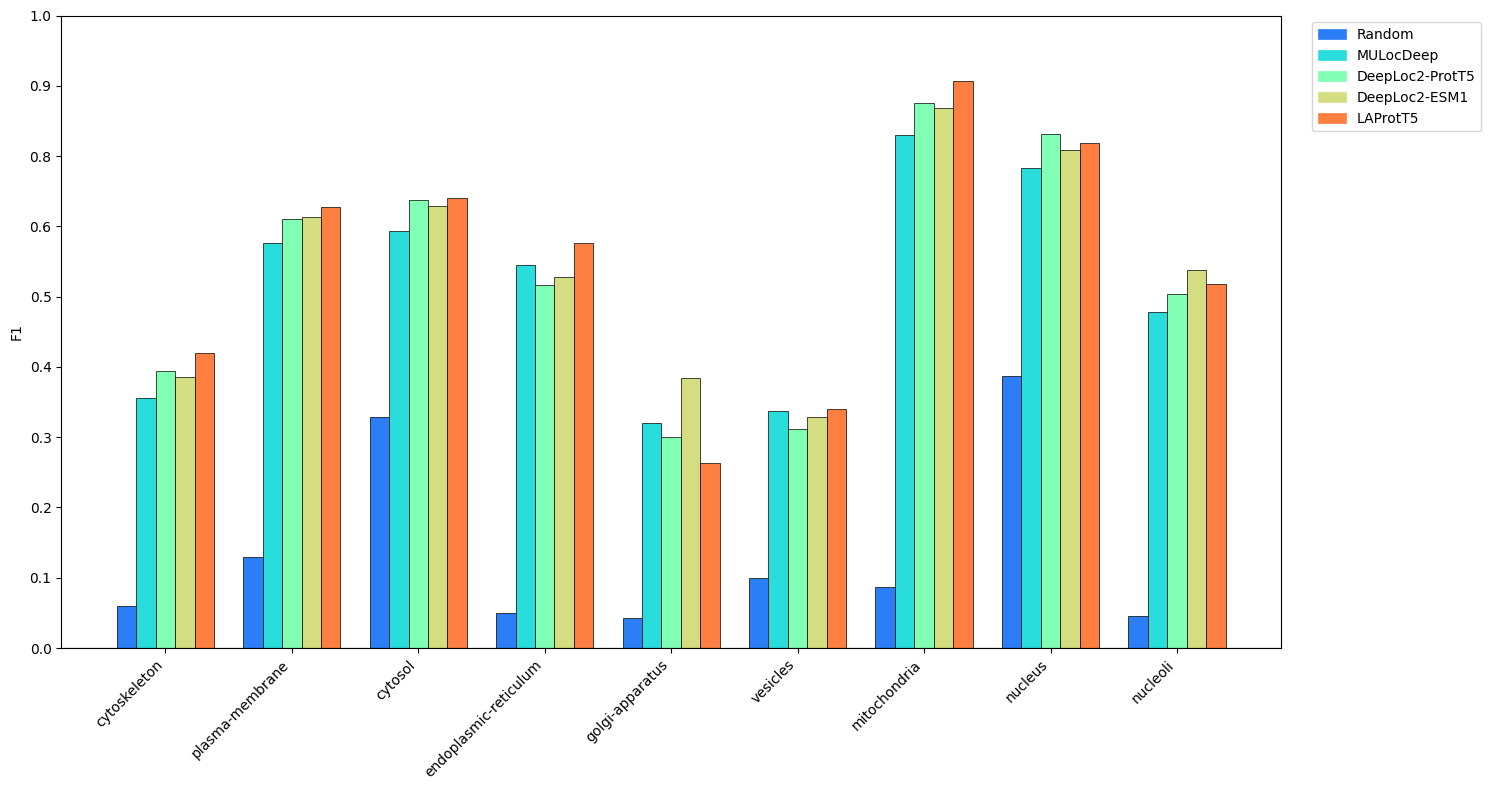

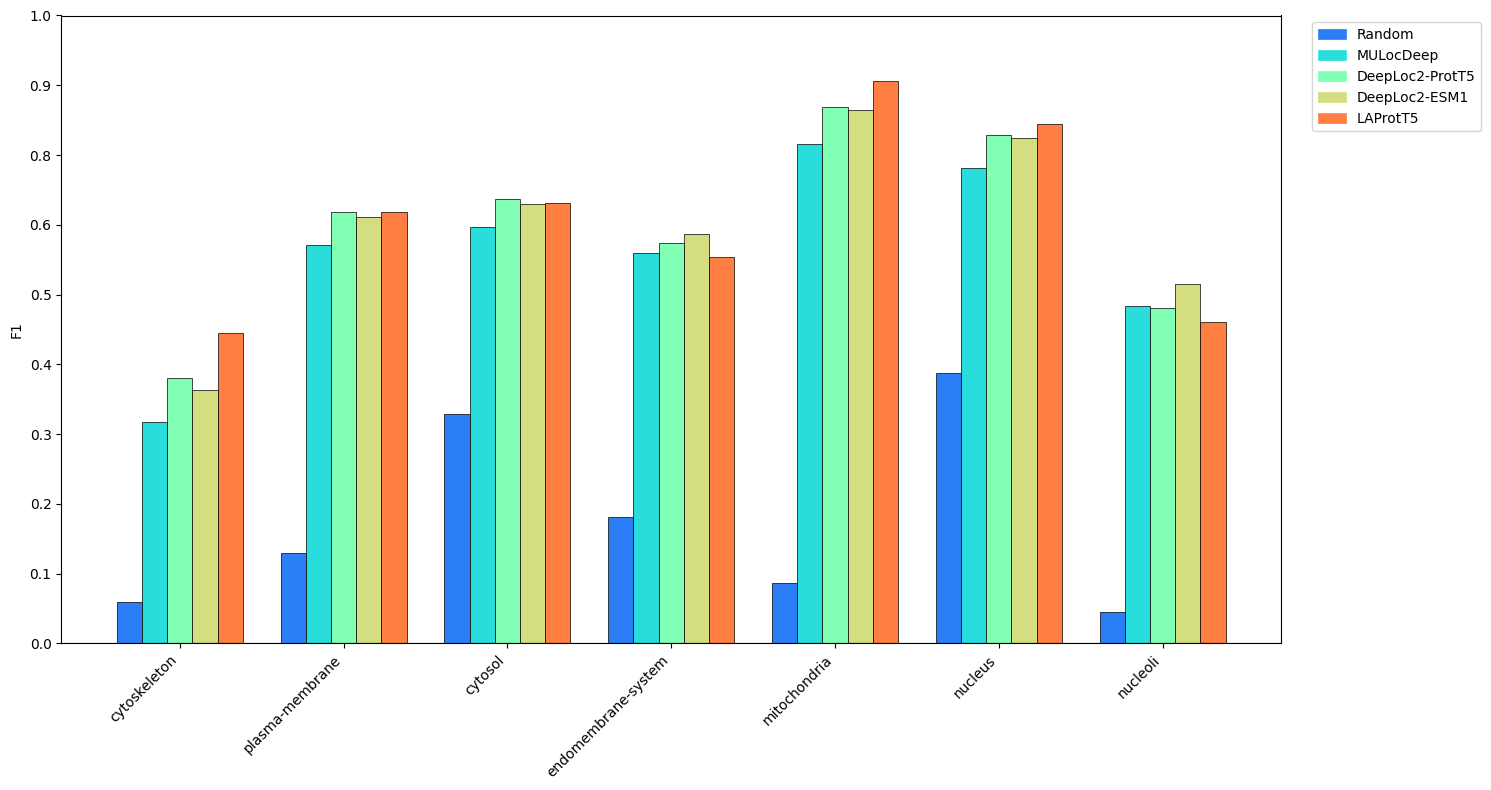

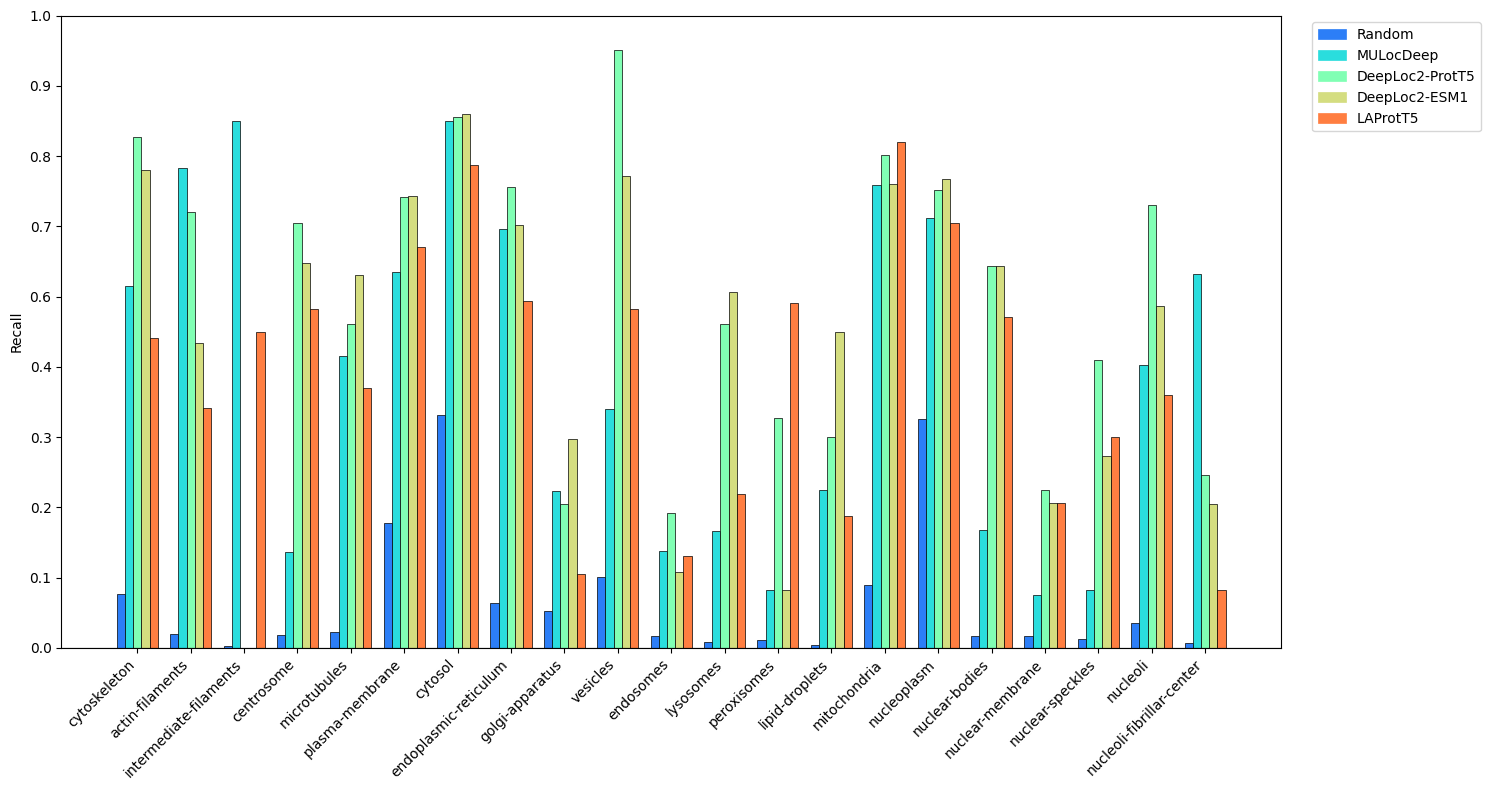

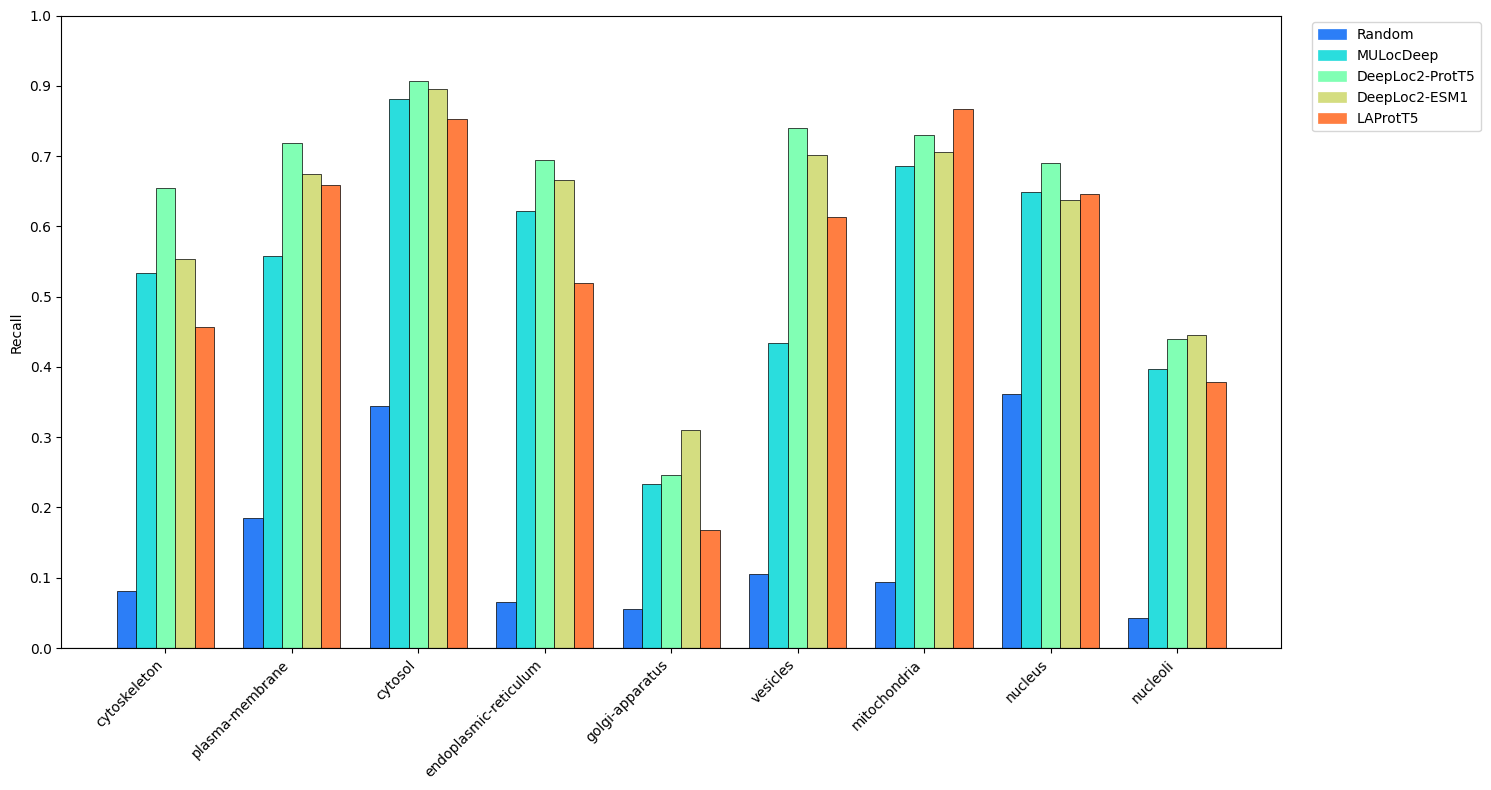

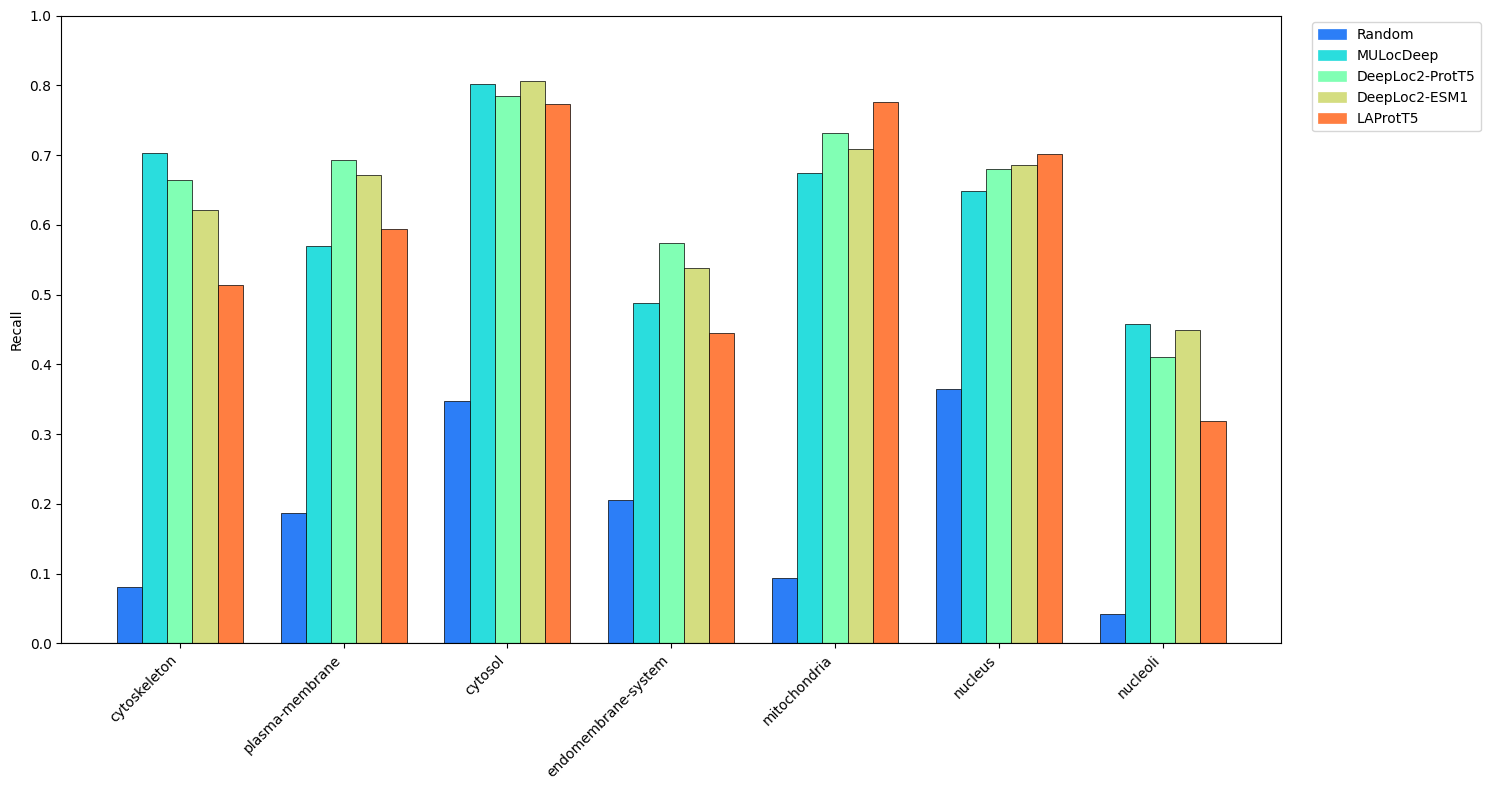

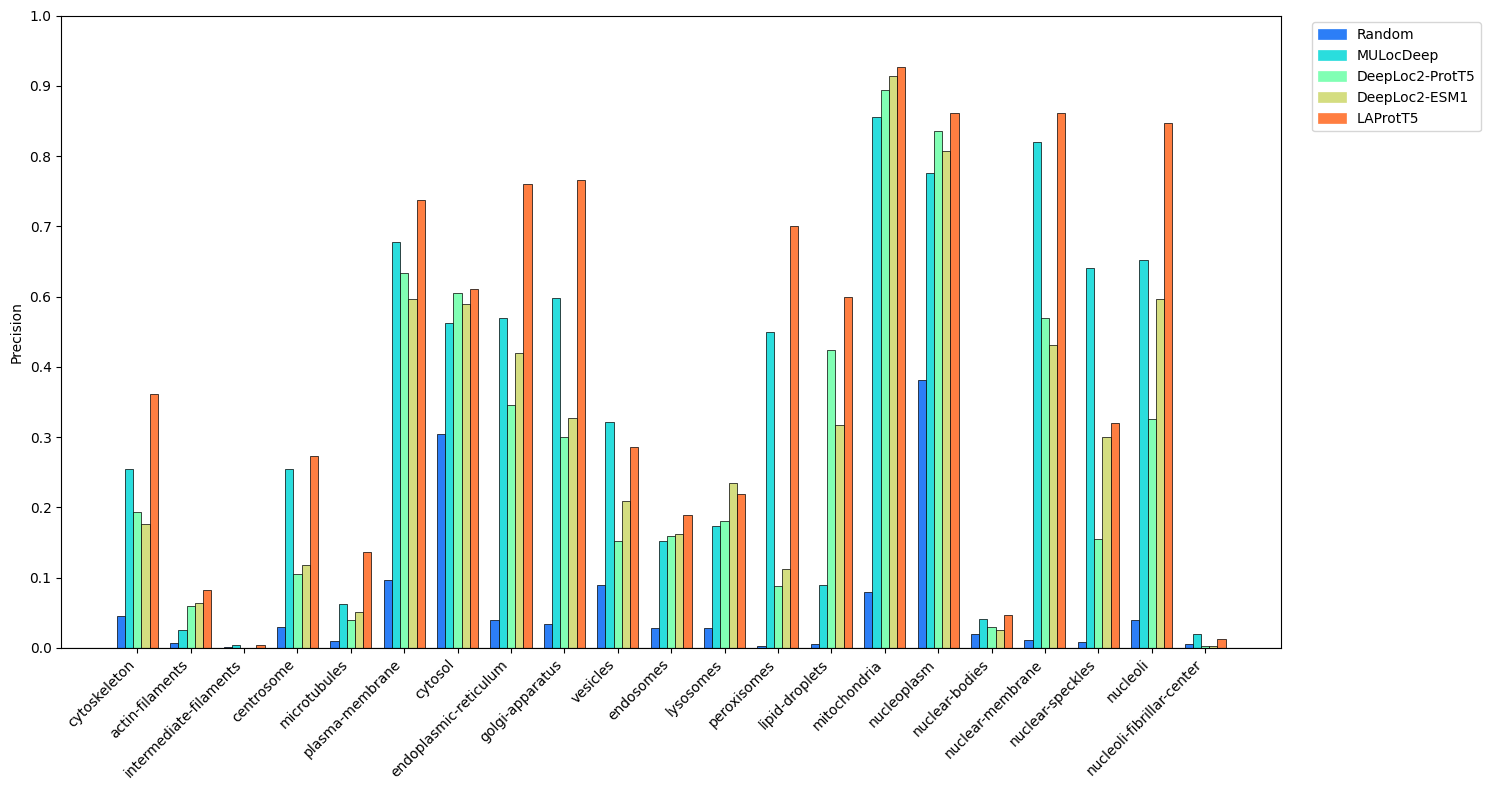

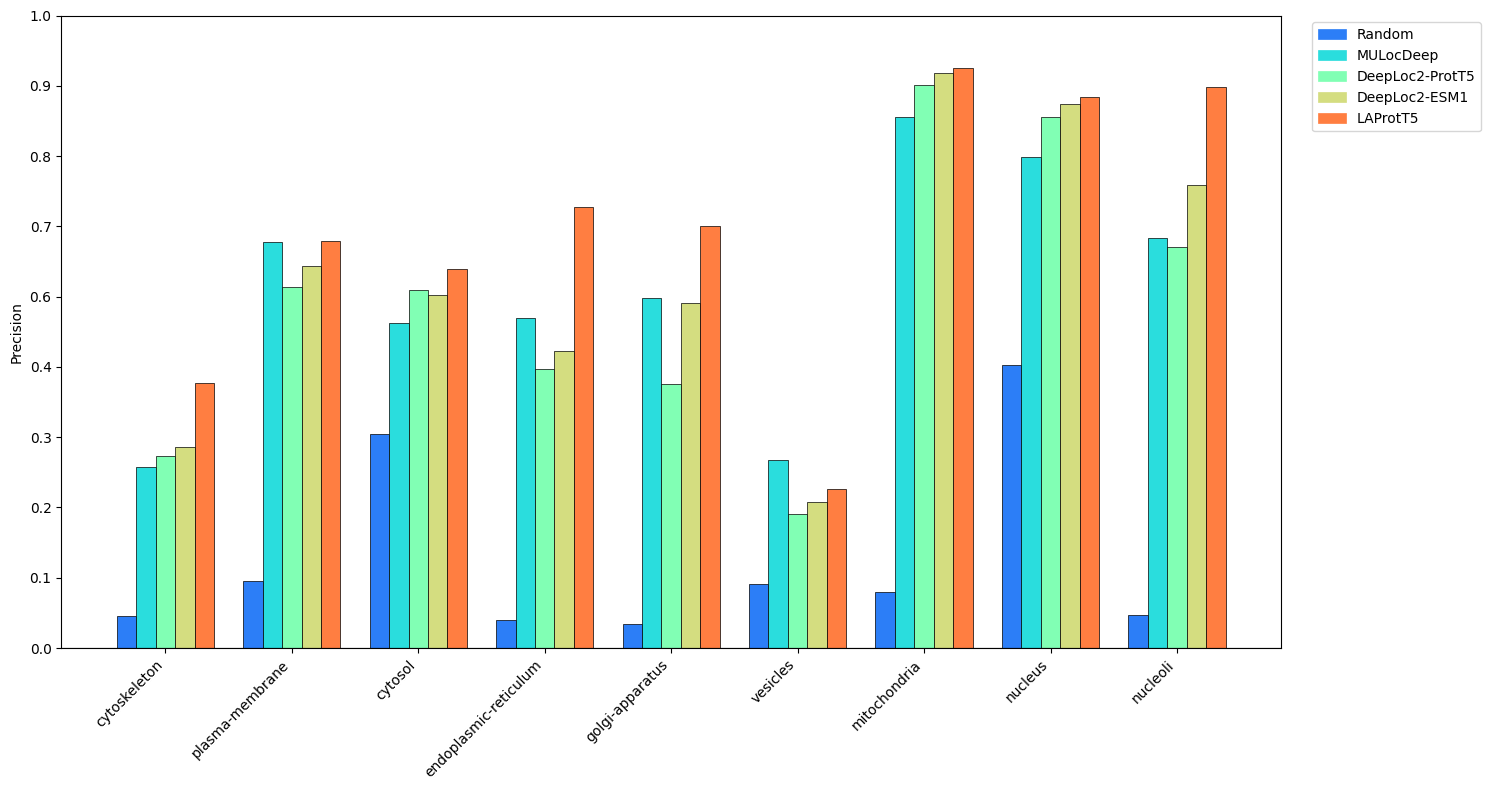

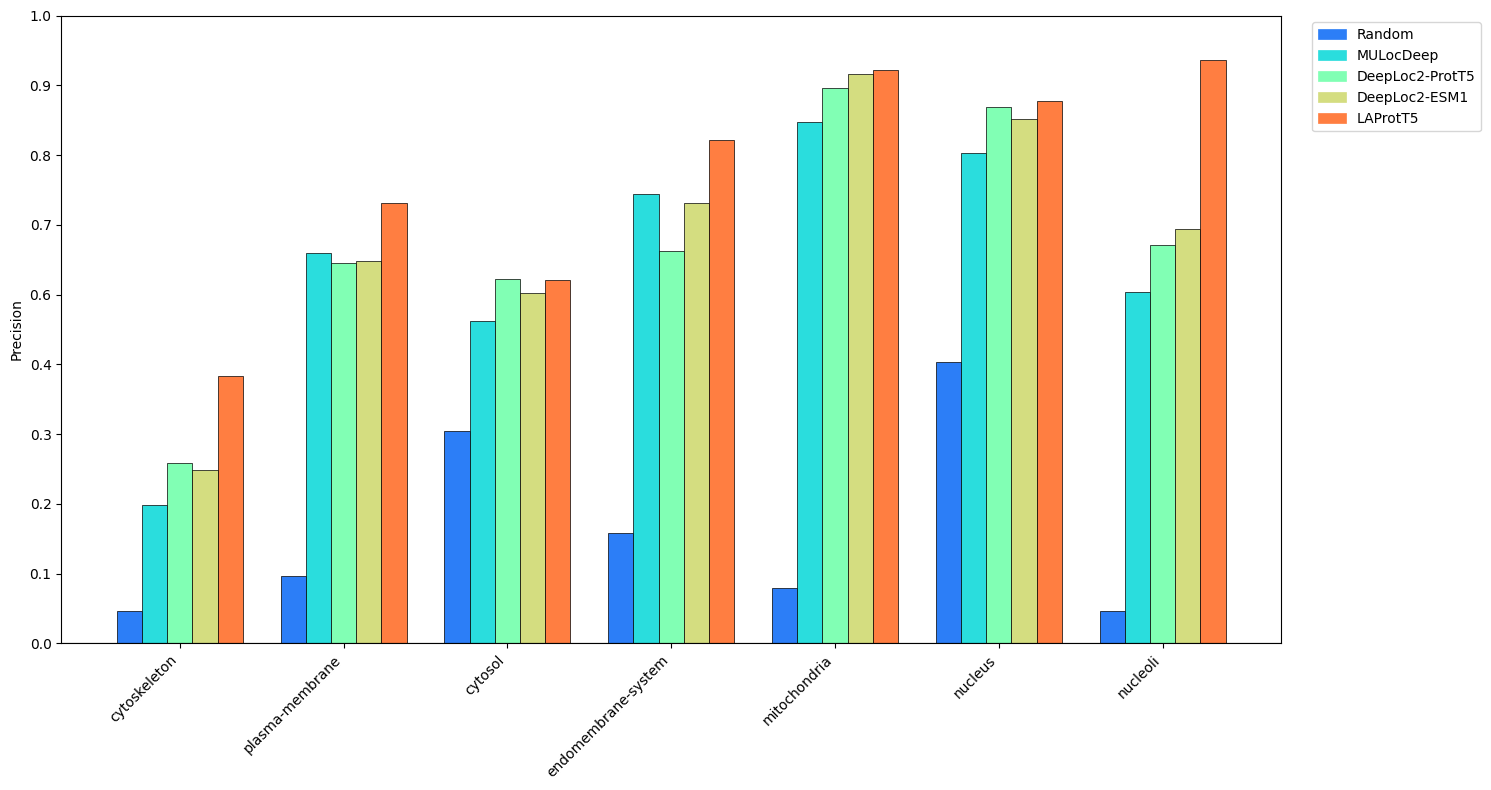

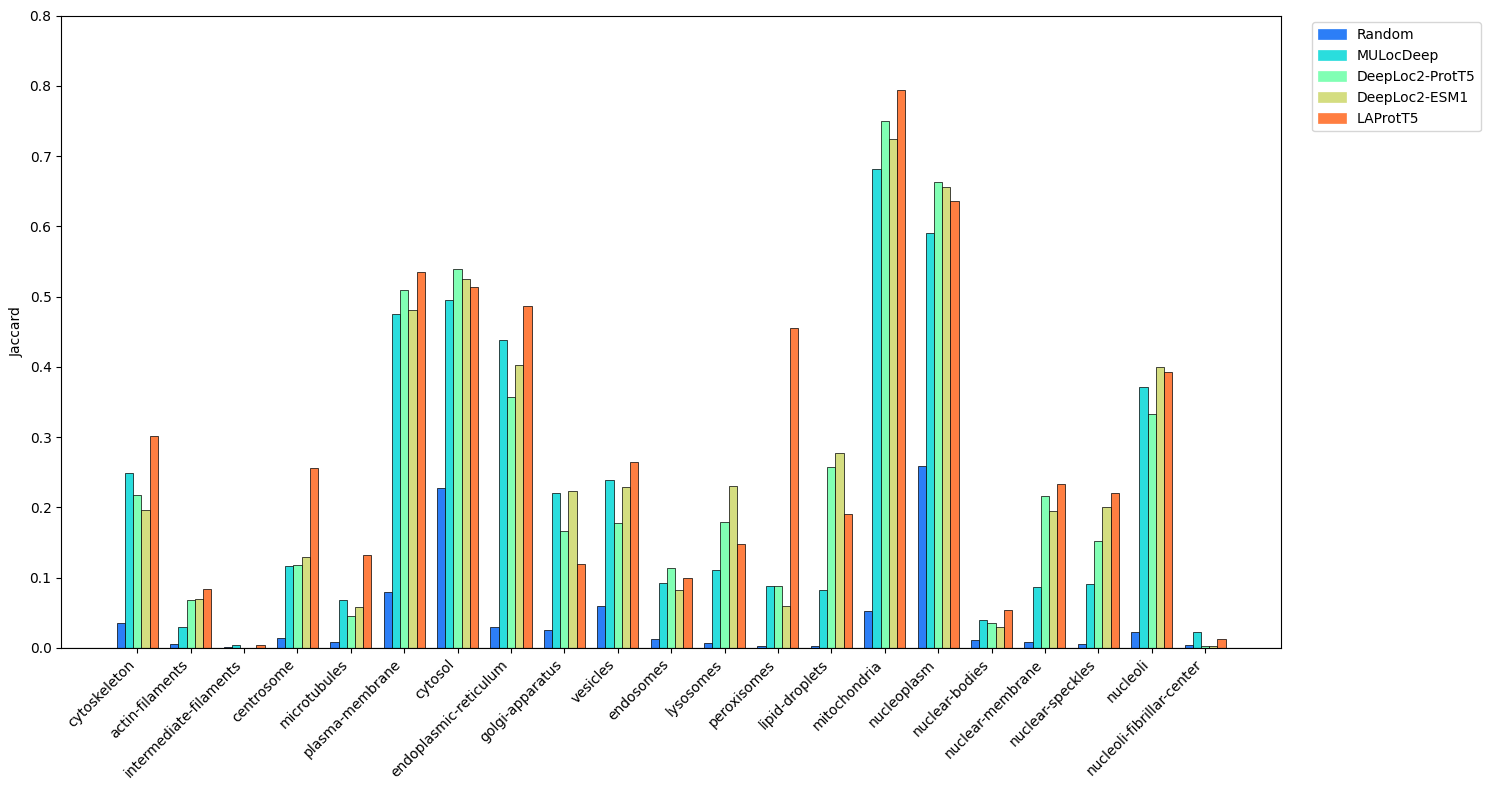

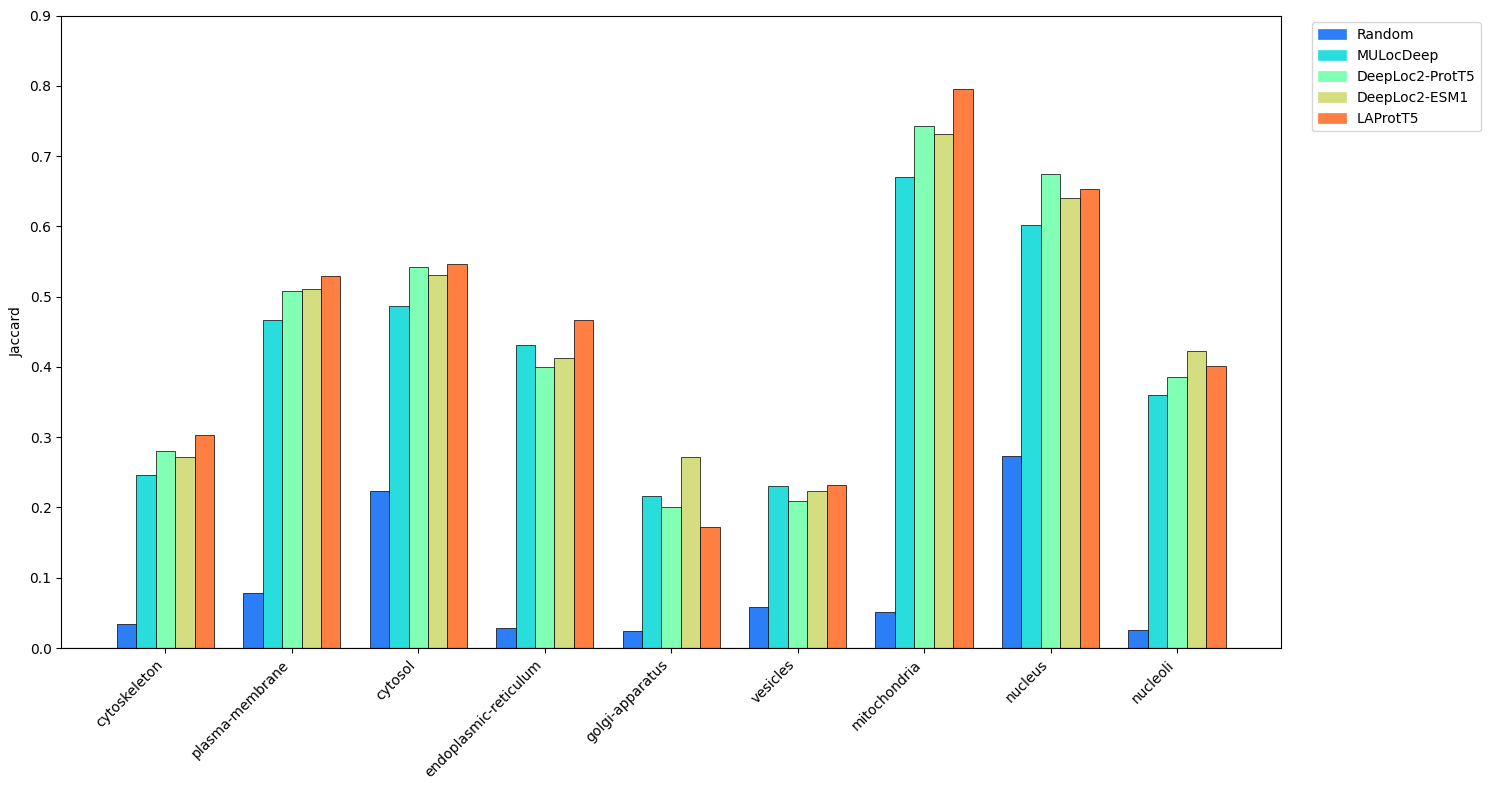

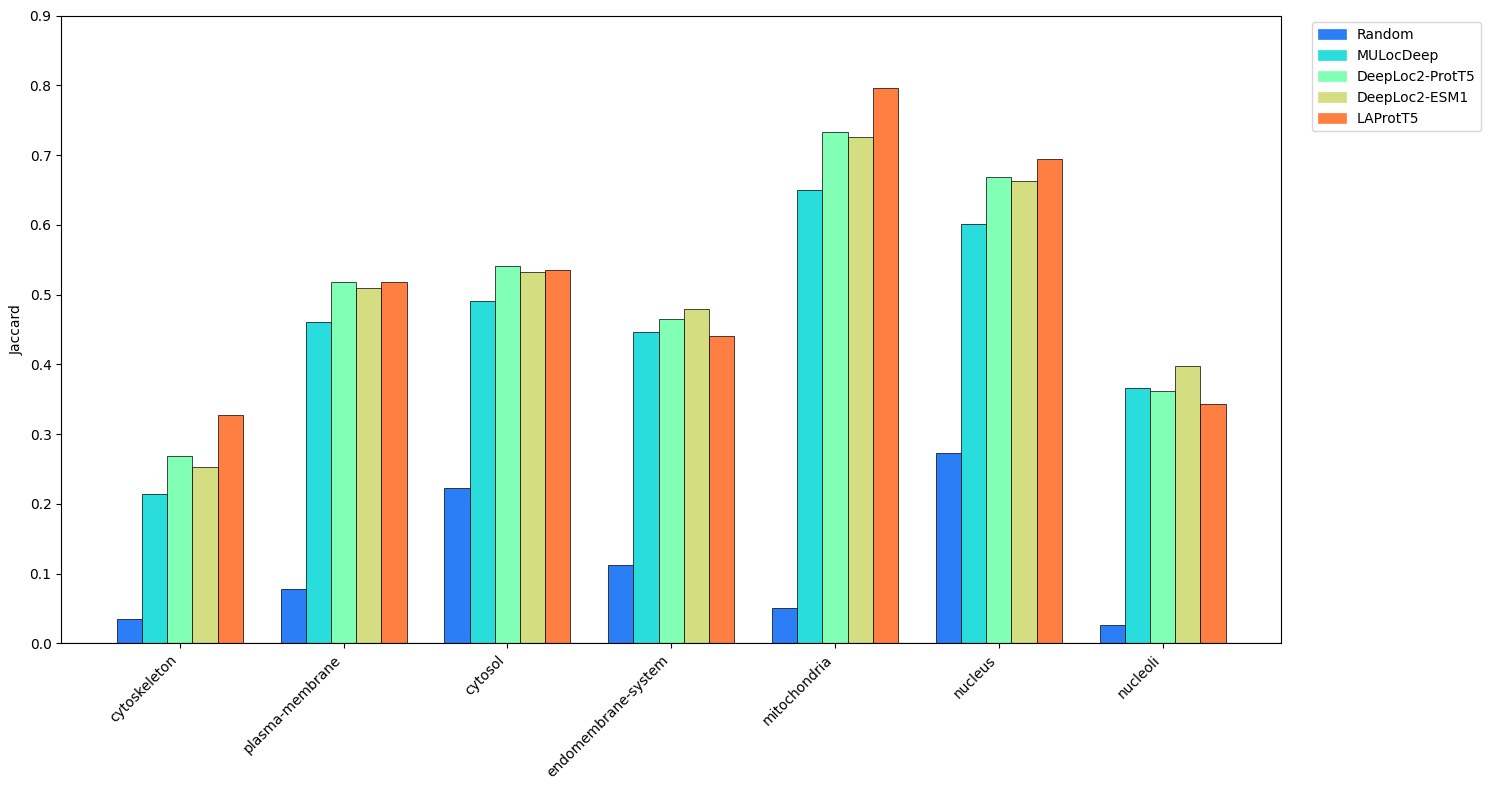

In [15]:
perclass = [test_perclass_level1, test_perclass_level2, test_perclass_level3]

metrics = ["mcc_perclass", "acc_perclass", "f1_perclass", "recall_perclass", "precision_perclass", "jaccard_perclass"]
metrics_names = ["MCC", "ACC", "F1", "Recall", "Precision", "Jaccard"]
for metric, name in zip(metrics, metrics_names):
    for level in [1,2,3]:
        fig, axes = plot_perclass_metrics(
            perclass[level-1],
            metric,
            name,
            models,
            model_colors,
            orders[level-1]
        )
        fig.savefig(f"{FIG_DIR}/{metric}_level{level}.pdf", bbox_inches='tight', dpi=300)

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

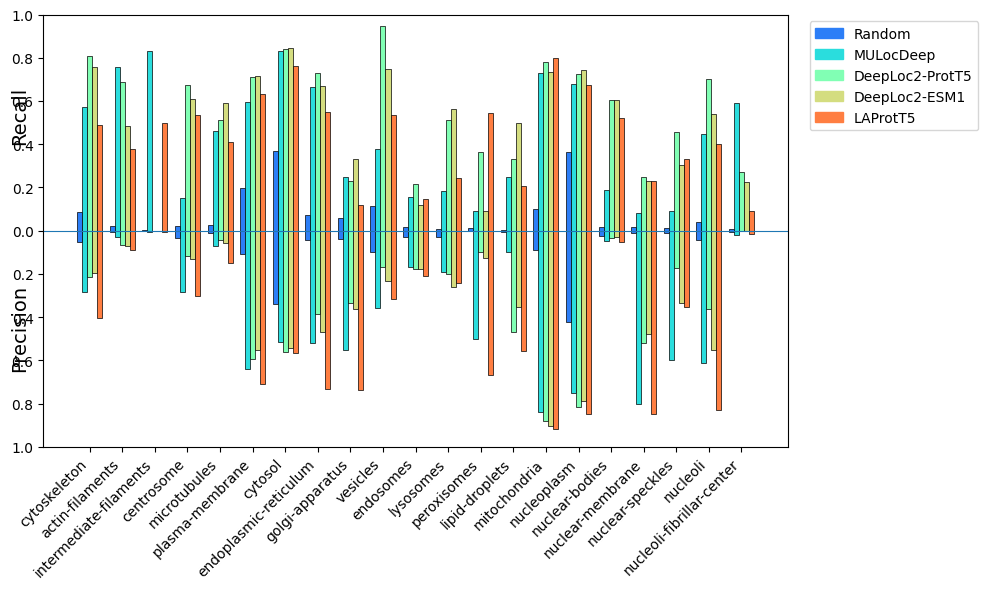

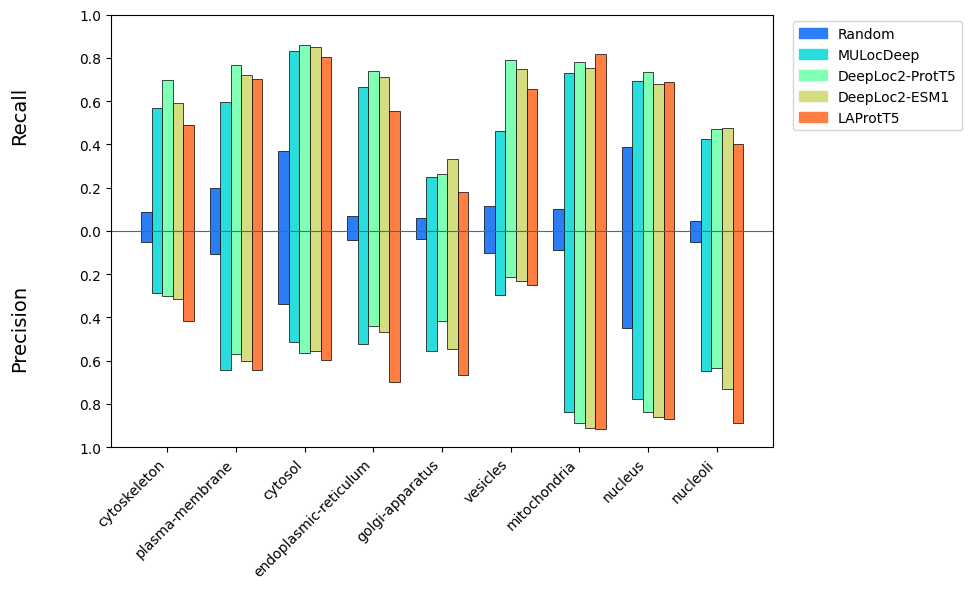

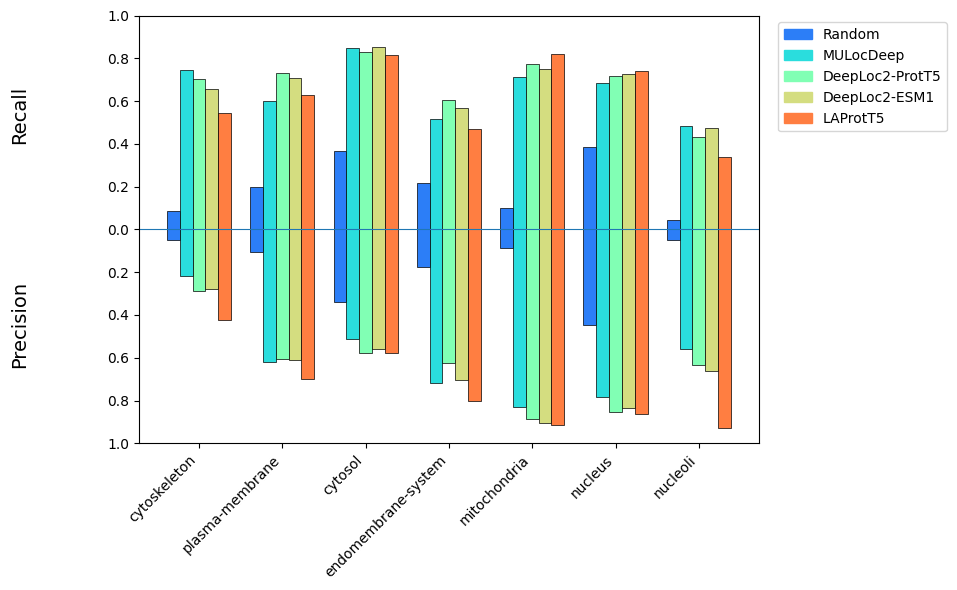

In [16]:
for level in [1,2,3]:
    fig, ax = plot_perclas_double_bar(
        perclass[level-1],
        {"Recall": "recall_perclass",
        "Precision": "precision_perclass"},
        models,
        model_colors,
        orders[level-1]
    )
    fig.savefig(f"{FIG_DIR}/precision_recall_level{level}.pdf", bbox_inches='tight', dpi=300)

In [17]:
for i in range(3):
    perclass[i]["level"] = i+1
perclass_all = pd.concat(perclass).drop("Unnamed: 0", axis=1).round(3)
perclass_all.to_csv(f"{FIG_DIR}/benchmark_perclass_metrics.csv")

Look at relationship between class size (in training set) and performance for different metrics

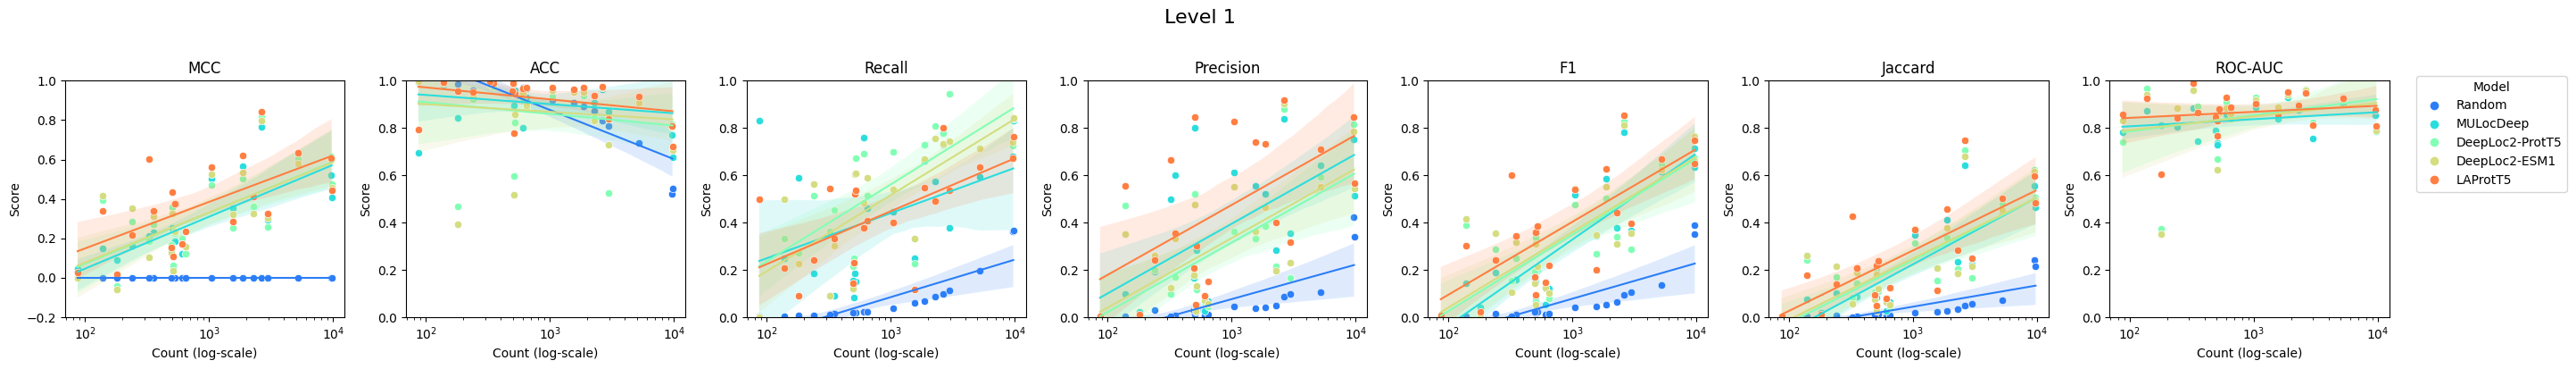

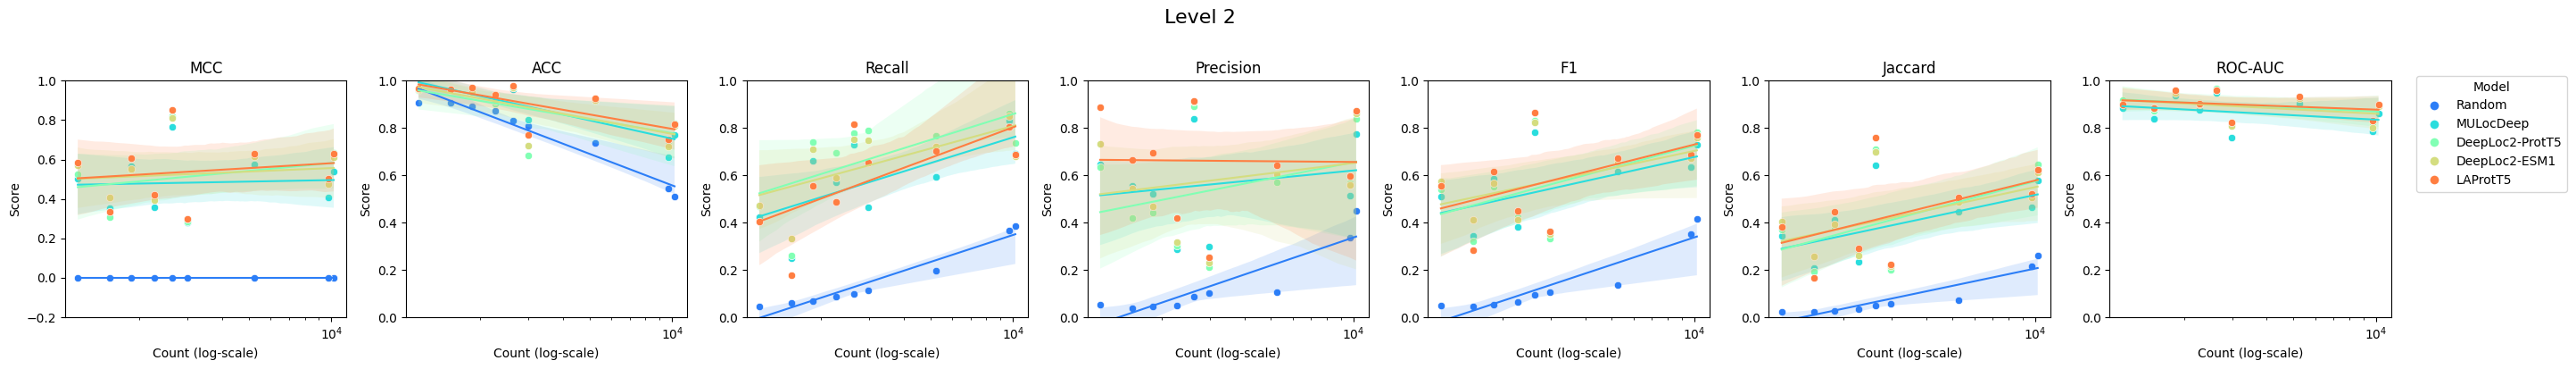

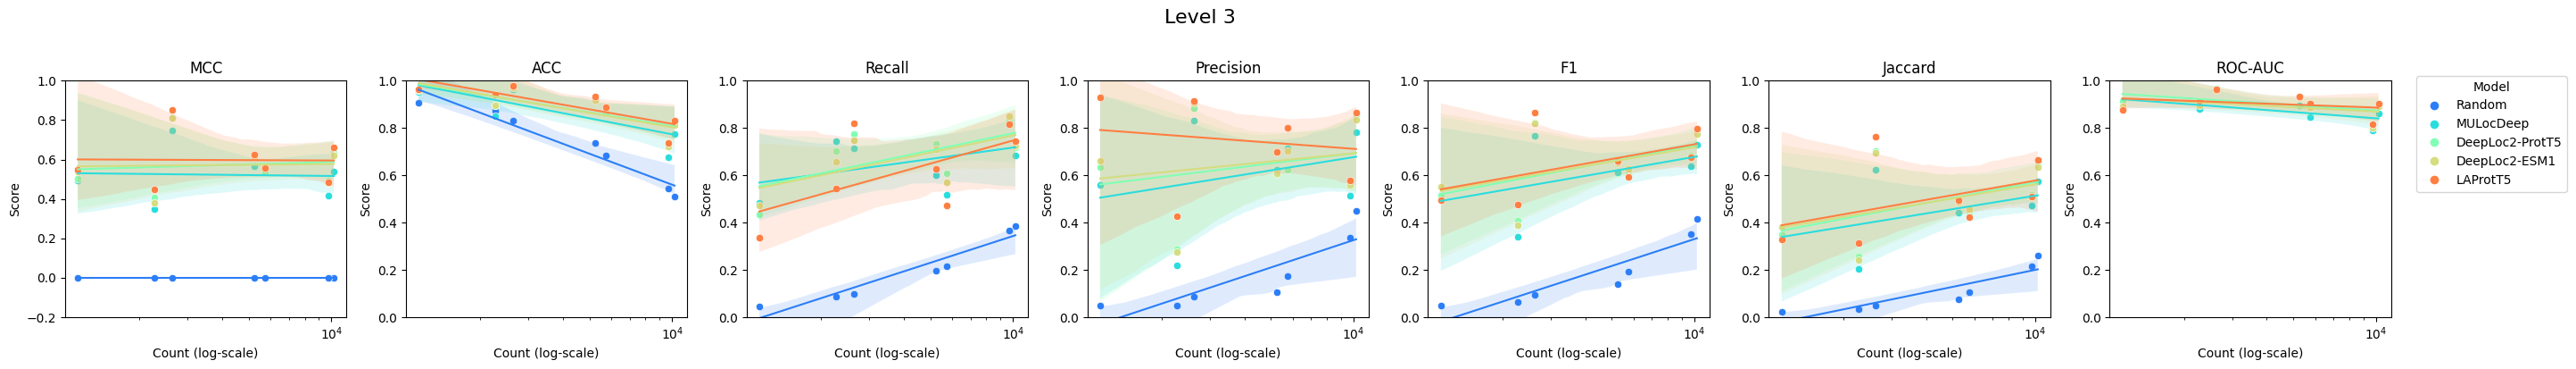

,level,mcc_perclass,acc_perclass,recall_perclass,precision_perclass,f1_perclass,jaccard_perclass,rocauc_perclass
model,,,,,,,,
Random,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MULocDeep,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DeepLoc2-ProtT5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DeepLoc2-ESM1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAProtT5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Random,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MULocDeep,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DeepLoc2-ProtT5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DeepLoc2-ESM1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
r2_values_df = []
metrics = ["mcc_perclass", "acc_perclass", "recall_perclass", 
           "precision_perclass", "f1_perclass", "jaccard_perclass", 
           "rocauc_perclass"]

metric_title = {metrics:title for metrics, title in zip(metrics, ["MCC", "ACC", "Recall", "Precision", "F1", "Jaccard", "ROC-AUC"])}

for level in range(1, 4):
    fig, axes = plt.subplots(1, len(metrics), figsize=(27, 4), sharex=False, sharey=False)
    # Count labels for current level
    all_locs = sum(hpa_uniprot_combined_trainset[f"level{level}"].str.split(";").to_list(), [])
    counter = Counter(all_locs)
    labels = list(counter.keys())
    counts = list(counter.values())

    # Initialize an empty list to store custom legend handles and labels
    handles_list = []
    labels_list = []

    for model in models:
        temp = perclass_all[(perclass_all.level == level) & 
                            (perclass_all.model == model)].set_index("label").reindex(labels)
        temp["counts"] = counts
        temp["model"] = model
        temp["level"] = f"Level {level}"

        r2_values= []
        for i, metric in enumerate(metrics):
            
            sns.scatterplot(
                data=temp, 
                x="counts", 
                y=metric, 
                color=model_colors[model],
                ax=axes[i],
                legend=False  # Disable legend for scatter plot
            )
            
            sns.regplot( #Compute LINEAR REGRESSION LINE
                data=temp,
                x="counts",
                y=metric,
                scatter=False,
                logx=True, #LOG SCALE for X Values
                line_kws={'color': model_colors[model], 'lw': 1.5},
                ax=axes[i],
            )
            axes[i].set_xscale("log")  # <-- Set x-axis to log scale
            if metric == "mcc_perclass":
                axes[i].set_ylim(-0.2, 1)
            else:
                axes[i].set_ylim(0, 1)

            x = np.log10(temp["counts"].to_numpy())
            y = temp[metric].to_numpy()
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            r_squared = r_value**2
            r2_values.append(r_squared)

            # Collect legend handles and labels manually for the last plot
            if i == len(metrics) - 1:  # Only add the legend to the last plot
                handle = Line2D([0], [0], marker='o', color='w', label=model,
                                markerfacecolor=model_colors[model], markersize=8)
                handles_list.append(handle)
                labels_list.append(model)

        r2_values_df.append([model, level] + r2_values)
    fig.suptitle(f"Level {level}", fontsize=16, y=1.02)  # Add figure-wide title indicating the level

    # Title and layout
    for ax, metric in zip(axes, metrics):
        ax.set_title(metric_title[metric])
        ax.set_xlabel("Count (log-scale)")
        ax.set_ylabel("Score")

    # Create a custom legend outside the figure
    fig.legend(
        handles_list, labels_list, title="Model",
        loc="upper right",
        bbox_to_anchor=(1.07, 0.85)
    )

    plt.tight_layout()
    fig.savefig(f"{FIG_DIR}/benchmark_CountsvsMetrics_level{level}.pdf", bbox_inches='tight', dpi=300)
    plt.show()


r2_values_df = pd.DataFrame(r2_values_df, columns = ["model", "level"] + metrics)
r2_values_df = r2_values_df.set_index("model").round(3)
display(r2_values_df)
r2_values_df.to_csv(f"{FIG_DIR}/r2_values.csv")

Look at performance of models on single vs multilocalizing proteins

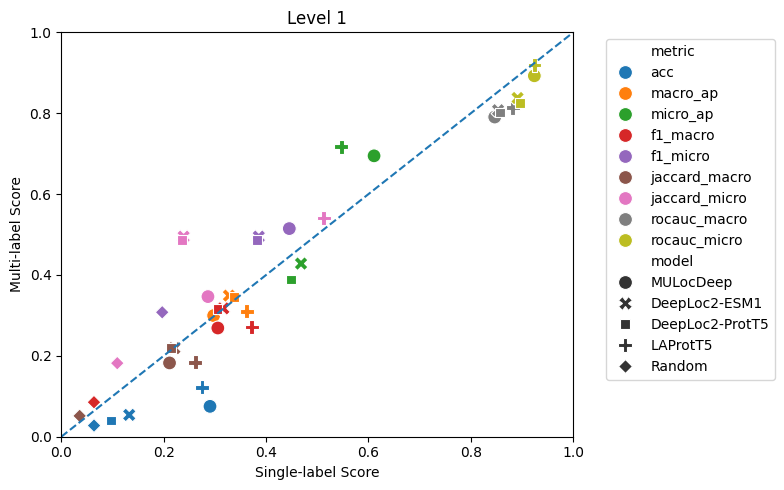

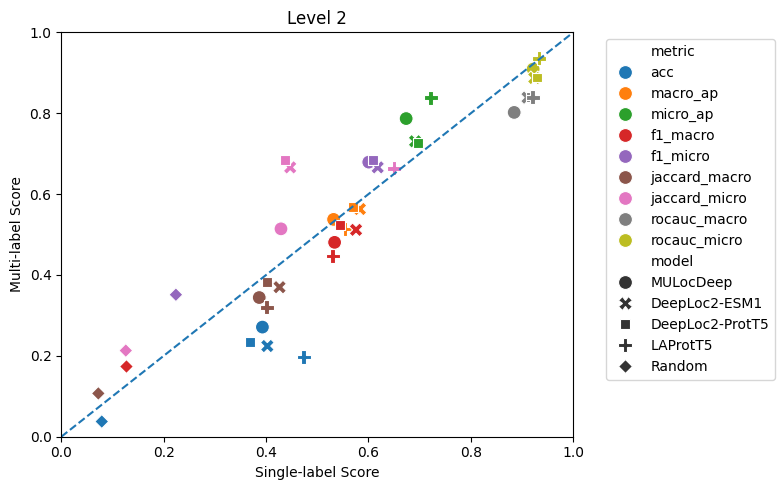

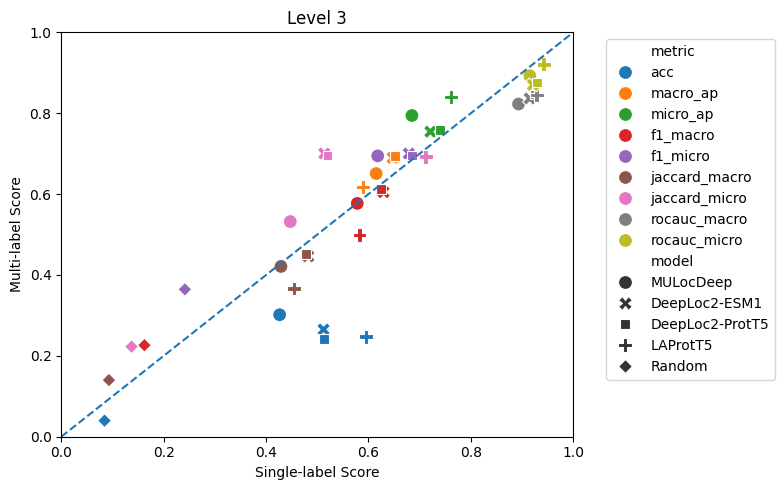

In [19]:
df = test_avgs_single.merge(test_avgs_multi, on=["model", "level"], suffixes=("_single", "_multi"))

metrics = [
    "acc", "macro_ap", "micro_ap", "f1_macro", "f1_micro",
    "jaccard_macro", "jaccard_micro", "rocauc_macro", "rocauc_micro"
]

# Melt the dataframe to long format for plotting
plot_data = []
for level in [1, 2, 3]:
    temp = df[df.level == level]
    for metric in metrics:
        for _, row in temp.iterrows():
            plot_data.append({
                "model": row["model"],
                "level": level,
                "metric": metric,
                "single": row[f"{metric}_single"],
                "multi": row[f"{metric}_multi"]
            })
plot_df = pd.DataFrame(plot_data)

for level in [1, 2, 3]:
    temp = plot_df[plot_df.level == level]
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(
        data=temp,
        x="single",
        y="multi",
        hue="metric",
        style="model",
        s=100,
        ax=ax
    )
    ax.set_xlim(0, 1)
    ax.set_xlabel("Single-label Score")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Multi-label Score")

    ax.plot([0, 1], [0, 1], ls="--")  # x=y line
    ax.set_title(f"Level {level}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/multi_vs_single_scatter_level{level}.pdf", dpi=300)
    plt.show()